# Introduction to transformers (attention mechanisms)

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/hftsoi/Penn_lectures/refs/heads/main/PHYS3359_Spring2025/img/img1.png" width="600"/>
</div>

We will introduce transformers, models that are built on attention mechanisms. First of all, why transformers? The short answer is "Attention Is All You Need" [[1706.03762](https://arxiv.org/abs/1706.03762)], the 2017 paper by Google that first proposed the architecture. Transformers were first developed to solve bottlenecks in natural language processing (NLP). In previous lectures you have seen BDTs, dense NNs, RNNs and etc. While they work great in many tasks, but real-world problems can exceed their limits. For example for NLP, traditional models like RNNs/LSTMs process tokens sequentially and store context with hidden states. For longer sequences (imagine with 1k input tokens) they suffer from slow training, vanishing gradients and long-range dependencies. Transformers can solve all of these at once with the attention mechanisms, which allow every token to interact directly (simultaneously) with every other tokens in parallel. This makes transformers able to scale to very large and complicated datasets, enabling applications like chatbots and multi-language translations etc.

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/hftsoi/Penn_lectures/refs/heads/main/PHYS3359_Spring2025/img/img2.png" width="300"/>
</div>

Although transformers were developed to primarily target NLP, but they are also found to outperform earlier models in many other fields. For example, in particle physics, the Particle Transformer (ParT) achieves better jet-tagging performance than graph-based models [[2202.03772](https://arxiv.org/abs/2202.03772)]

We will take a look at how attention works. The 2017 paper introduced the scaled dot-product attention as pictured below (source: [1706.03762](https://arxiv.org/abs/1706.03762)).

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/hftsoi/Penn_lectures/refs/heads/main/PHYS3359_Spring2025/img/attention.png" width="300"/>
</div>

Basically, attention is computed using three components: Query (Q), Key (K), and Value (V). Lets first understand what these are with a much simplified analogy from performing a Google search:
- Query: your search phrase (to question: what information am I looking for)
- Key: all web titles/descriptions on the internet (to match: references to be checked when someone asks)
- Value: content of those webs (to answer: what information should I carry after question-references matching)

Consider an input sequence, each embedded token is projected through linear maps into three different vectors: a query vector, a key vector, and a value vector. The query vector represents the "question" from the current token that is seeking information for by comparing itself to all other tokens in the input. The key vectors represent the "descriptions" of all tokens that serve as references for comparing how relevant are they to the incoming query. The relevance is computed by a similarity score called attention for each query-key pair, which tells how much the current token needs to focus on each of the tokens in the input. Then the value vectors represent the actual content to be aggregated, which are to be weighted by the attention scores that are learned to encode the relevant contextual information.

The scaled dot-product attention is computed as ``attention(Q,K)V = softmax(QK^T/sqrt(d_k))V``, pictured above. Here, query vectors are stacked to form the ``Q`` matrix which has a shape of ``(seq_length, query_dim)``; key and value vectors are stacked similarly to form the ``K`` and ``V`` matrices as well. The similarity between queries and keys are measured by their dot-products ``QK^T``, where the i-th row at j-th col represents the i-th query dotted with the j-th key. The dot-products are scaled by the sqrt of their dim ``sqrt(d_k)`` to smoothen the softmax function when ``d_k`` is large (large softmax arguments tend to saturate it and make gradients small). Then a softmax is taken per row (per the same query) to yield probability-like weights. These give the attention matrix ``softmax(QK^T/sqrt(d_k))`` which encodes the relevance between all query-key pairs. The attention matrix is then to weigh the value vectors so that the output carry extracted contextual information. For example, you can take a look at the picture below that illustrates how "I am hungry" is encoded with the self-attention mechanism.

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/hftsoi/Penn_lectures/refs/heads/main/PHYS3359_Spring2025/img/attention_example.png" width="1000"/>
</div>

Through the attention matrix, you can see that each token can directly attend to all other input tokens simultaneously, regardless of their position. This eliminates the problem of long-range memory decay that occurs in sequential models like RNNs/LSTMs. In transformers, memory of distant tokens does not fade over time, hence the only limitation here is from hardware memory.

So far, we have discussed a single attention head. But there is no reason we cant do multiple attentions in parallel, each learns to focus on different aspects of the context, and then aggreate the weights after. You can think of this like sliding multiple filters in a convolutional layer. The multihead attention is illustrated in the picture below (source: [1706.03762](https://arxiv.org/abs/1706.03762)).

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/hftsoi/Penn_lectures/refs/heads/main/PHYS3359_Spring2025/img/multihead.png" width="300"/>
</div>

Putting these together, the full vanilla transformer looks like below (source: [1706.03762](https://arxiv.org/abs/1706.03762)):

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/hftsoi/Penn_lectures/refs/heads/main/PHYS3359_Spring2025/img/arch.png" width="400"/>
</div>

First, the input tokens are embedded into higher-dimensional vector spaces. This model targets translation between two languages, where word ordering matters in a text sequence, so there is a positional embedding to encode this information. This is needed because the attention modules are permutation-equivariant (swapping input tokens would swap the output tokens correspondingly). The embedded inputs are fed to a stack of encoder blocks. Each encoder block consists of a multi-head attention module (self-attention) for extracting contextual relationship, which is followed by a feedforward NN to update the representations. You can think of the encoder as a model to encode inputs to a contextual representation. The decoder is then a translation model, which is responsible for generating output sequences. There are two multi-head attention modules in the decoder. The first one is a masked self-attention, which allows the decoder to attend to positions only up to the current position when generating output texts. The second one is a cross-attention, where the queries come from the decoder, while keys and values come from the encoder.

Now that we have a basic understanding of transformers, we will move on to some hands-on experiments: 1) classifying sentiment of movie review texts from the IMDB dataset, and 2) jet flavor tagging in particle physics from the jetnet dataset.

## demo: text sentiment classification

We will look at the IMDB moive review sentiment classification dataset from keras ([source](https://keras.io/api/datasets/imdb/)). This is a dataset of movie reivews retrieved from IMDB, each corpus is labeled by a binary-sentiment (1=positive and 0=negative). The task is to train a model to understand a given review and predict its sentiment, so a binary classification problem. Lets first load the dataset from keras.

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import numpy as np

In [3]:
num_words = 20000 # only consider the top {num_words} words (ranked by appearance frequency in the dataset), infrequent words are padded with {oov_char}
maxlen = 200  # only consider the first {maxlen} words in each input sequence
start_char = 1 # token value that signals the start of a sequence
oov_char = 2 # token value that pads the truncated infrequent words
index_from = 3 # real word token starts from this value

(x_train, y_train), (x_val_test, y_val_test) = keras.datasets.imdb.load_data(
    num_words=num_words,
    start_char=start_char,
    oov_char=oov_char,
    index_from=index_from,
    )

# further split into val/test sets
n_val_test_half = x_val_test.shape[0]//2
x_val, x_test = x_val_test[:n_val_test_half], x_val_test[n_val_test_half:]
y_val, y_test = y_val_test[:n_val_test_half], y_val_test[n_val_test_half:]

# pad the sequences with a fixed length of {maxlen}
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

print(len(x_train), "train sequences")
print(len(x_val), "val sequences")
print(len(x_test), "test sequences")

25000 train sequences
12500 val sequences
12500 test sequences


It is a very small dataset, especially for language processing! A too small train set is prone to overfitting, so just move a bit more corpuses from val/test into the train set to remedy the overtraining for later, though there should still be quite significant overtraining in such setup.

In [4]:
NEW_VAL_SIZE = 6000
NEW_TEST_SIZE = 6000

x_val_extra = x_val[NEW_VAL_SIZE:]
y_val_extra = y_val[NEW_VAL_SIZE:]
x_test_extra = x_test[NEW_TEST_SIZE:]
y_test_extra = y_test[NEW_TEST_SIZE:]

x_val, y_val   = x_val[:NEW_VAL_SIZE], y_val[:NEW_VAL_SIZE]
x_test, y_test  = x_test[:NEW_TEST_SIZE], y_test[:NEW_TEST_SIZE]

x_train = np.concatenate([x_train, x_val_extra, x_test_extra], axis=0)
y_train = np.concatenate([y_train, y_val_extra, y_test_extra], axis=0)

print(len(x_train), "train sequences")
print(len(x_val), "val sequences")
print(len(x_test), "test sequences")

38000 train sequences
6000 val sequences
6000 test sequences


Now lets take a look to understand a bit more about the dataset.

In [5]:
print(x_train.shape)
print(x_train[1])

(38000, 200)
[    0     0     0     0     0     0     0     0     0     0     0     1
   194  1153   194  8255    78   228     5     6  1463  4369  5012   134
    26     4   715     8   118  1634    14   394    20    13   119   954
   189   102     5   207   110  3103    21    14    69   188     8    30
    23     7     4   249   126    93     4   114     9  2300  1523     5
   647     4   116     9    35  8163     4   229     9   340  1322     4
   118     9     4   130  4901    19     4  1002     5    89    29   952
    46    37     4   455     9    45    43    38  1543  1905   398     4
  1649    26  6853     5   163    11  3215 10156     4  1153     9   194
   775     7  8255 11596   349  2637   148   605 15358  8003    15   123
   125    68     2  6853    15   349   165  4362    98     5     4   228
     9    43     2  1157    15   299   120     5   120   174    11   220
   175   136    50     9  4373   228  8255     5     2   656   245  2350
     5     4  9837   131   152   491  

The input sequences have already been preprocessed/tokenized in the original dataset (i.e. each word is represented by a unique integer: "the" -> 4).

You can see that the word count of each corpus is truncated at ``maxlen=200`` to ensure a fixed input size. For those that have less than ``maxlen=200`` words, the null tokens are padded by 0. After the 0's, you can also see there is a 1, which corresponds to ``start_char=1`` that signals the start of the real content. The 2's correspond to ``oov_char=2``, the truncated infrequent words. We also set ``index_from=3``, the real tokens actually start from 4, where 4 represents the most frequent word in this dataset, 5 is the second most frequent, ...

Now, we need a dictionary to map between tokens and words to see the actual reivew corpuses. We can load this from the dataset.

In [6]:
word_to_index = keras.datasets.imdb.get_word_index()
for k, v in list(word_to_index.items())[:10]:
    print(k, " ", v)

fawn   34701
tsukino   52006
nunnery   52007
sonja   16816
vani   63951
woods   1408
spiders   16115
hanging   2345
woody   2289
trawling   52008


This ``word_to_index`` stores words as keys and tokens as values. For convenience, lets invert it to make ``index_to_word_raw`` and take a look at a few top (most frequently appearing) words.

In [7]:
index_to_word_raw = {v:k for k,v in word_to_index.items()}
for i in range(20):
    print(i+1, " ", index_to_word_raw[i+1])

1   the
2   and
3   a
4   of
5   to
6   is
7   br
8   in
9   it
10   i
11   this
12   that
13   was
14   as
15   for
16   with
17   movie
18   but
19   film
20   on


Here ``index_to_word_raw`` starts from 1, so ``PADDING=0`` is fine but it does not assume  ``start_char=1`` ``oov_char=2`` ``index_from=3``, so we will make a new ``index_to_word`` to offset these positions in order to have the correct mapping. Note that ``index_from=3`` could be misleading, actually index 3 is empty and real tokens start from 4.

In [8]:
index_to_word = dict((i + index_from, word) for (word, i) in word_to_index.items())
for k, v in list(index_to_word.items())[:10]:
    print(k, " ", v)

index_to_word[0] = "[PAD]"
index_to_word[start_char] = "[START]"
index_to_word[oov_char] = "[OOV]"

for i in range(10):
    if i != 3:
        print(i, " ", index_to_word[i])

34704   fawn
52009   tsukino
52010   nunnery
16819   sonja
63954   vani
1411   woods
16118   spiders
2348   hanging
2292   woody
52011   trawling
0   [PAD]
1   [START]
2   [OOV]
4   the
5   and
6   a
7   of
8   to
9   is


Now we have the correct mapping between token and word, lets convert x back to actual word sequences using this mapping.

In [9]:
import textwrap
def sequence_decoding(index_to_word, x, ignore_pad=False):
    words = []
    for token_id in x:
        word = index_to_word.get(int(token_id), "[UNK]")
        if ignore_pad and (word == "[PAD]" or word == "[START]"):
            continue
        words.append(word)
    return " ".join(words)

for j in range(3):
    decoded_sequence = sequence_decoding(index_to_word, x_test[j], ignore_pad=False)
    print(f"decoded x_test[{j}] (y_test[{j}]={y_test[j]}):\n\n" + textwrap.fill(decoded_sequence, width=120) + "\n")

decoded x_test[0] (y_test[0]=0):

[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [START] crap i accidentally watched this film thinking that it was
the swimming [OOV] that was released in 2003 i seriously regret wasting an hour of my life sitting through it shame on
whoever gave this junk an award i thoroughly loathed this film in fact i didn't see it through to the end after an hour
i could no longer stand it i am disgusted that people are amused by such a lousy script which tries and fails to rip off
a doz

Print again without ``[PAD]`` and ``[START]``

In [10]:
for j in range(3):
    decoded_sequence = sequence_decoding(index_to_word, x_test[j], ignore_pad=True)
    print(f"decoded x_test[{j}] (y_test[{j}]={y_test[j]}):\n\n" + textwrap.fill(decoded_sequence, width=120) + "\n")

decoded x_test[0] (y_test[0]=0):

crap i accidentally watched this film thinking that it was the swimming [OOV] that was released in 2003 i seriously
regret wasting an hour of my life sitting through it shame on whoever gave this junk an award i thoroughly loathed this
film in fact i didn't see it through to the end after an hour i could no longer stand it i am disgusted that people are
amused by such a lousy script which tries and fails to rip off a dozen other human interest stories and such ba ad
acting painful i rate it 1 star out of 10 an amateur could make a much much greater movie

decoded x_test[1] (y_test[1]=0):

fun with dick and jane failed to entertain on so many levels there were loose ends with the writing for example it seems
as though one of the major conflicts was the indictment of jim carrey's character dick harper but the writers never
follow up that particular conflict basically the story is weak and mostly unfunny but carrey saves a few scenes with his
physical hum

Now lets build our transformer. It should be tiny enough that we can quickly run and see results in class, but should be able to make reasonable predictions on this simple task. We will later load a pretrained transfomer and fine tune for this dataset.

We need an embedding layer ``TokenEmbedding`` that first embeds each token from a single integer into a dense vector of length ``embed_dim``, and then it creates a positional embedding that encodes the positions of the tokens, since the input sequences do not contain positional information.

Note that the transformer block is permutation-equivariant, meaning that the attention outputs are swapped in the same order as the inputs. This can be seen

Then we build the ``TransformerBlock`` that 

In [11]:
class TokenEmbedding(Layer):
    def __init__(self, maxlen, num_words, embed_dim):
        super().__init__()
        # input_dim: number of unique tokens
        # for token embedding, there are {num_words} unique tokens (embedding on words)
        # for position embedding, there are {maxlen} unique tokens (embedding on positions: 0, 1, ..., {maxlen} per sequence)
        self.token_emb = Embedding(input_dim=num_words, output_dim=embed_dim) # output shape (batch, input_length=maxlen, output_dim=embed_dim)
        self.position_emb = Embedding(input_dim=maxlen, output_dim=embed_dim) # output shape (batch, input_length=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = keras.ops.shape(x)[-1]
        positions = self.position_emb(keras.ops.arange(start=0, stop=maxlen, step=1))
        x = self.token_emb(x)
        return x + positions
    
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)]) # a feedforward network then a linear projection back to embedding dim
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs) # (query, value) input pair, key is assumed to be value if not given. here self-attention q=k=v.
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [12]:
embed_dim = 32
num_heads = 3
ff_dim = 32

# for demo lets fix a random seed to get reproducible initialization and results
import os
import random
os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

x_in = Input(shape=(maxlen,))
x = TokenEmbedding(maxlen, num_words, embed_dim)(x_in)
x = TransformerBlock(embed_dim, num_heads, ff_dim, 0.2)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=x_in, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding                 │ (None, 200, 32)        │       646,400 │
│ (TokenEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 32)        │        14,848 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 661,929 (2.53 MB)

 Trainable params: 661,929 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Before training, we can first visualize what the embedding looks like. We already set ``embed_dim=32``, which means each token is represented by a 32-dim vector, we can project them into 2D using ``PCA`` (principle component analysis) and draw the vectors for a few common words.

In [13]:
token_layer = model.get_layer(index=1).token_emb
token_w = token_layer.get_weights()[0] # (num_words, embed_dim)

print("embedding matrix shape:", token_w.shape)

words = [
    "good", "excellent", "great", "cool", "nice", "awesome", "amazing", "fantastic", "fun",
    "bad",  "worst", "awful", "terrible", "trash", "garbage", "waste", "poor", "horrible",
    "movie", "film",
    "the", "and", "to", "of", "which", "that",
]

words_idx = [word_to_index[word] + index_from for word in words]
emb_vec_init = token_w[words_idx] # (len(words), embed_dim)

embedding matrix shape: (20000, 32)


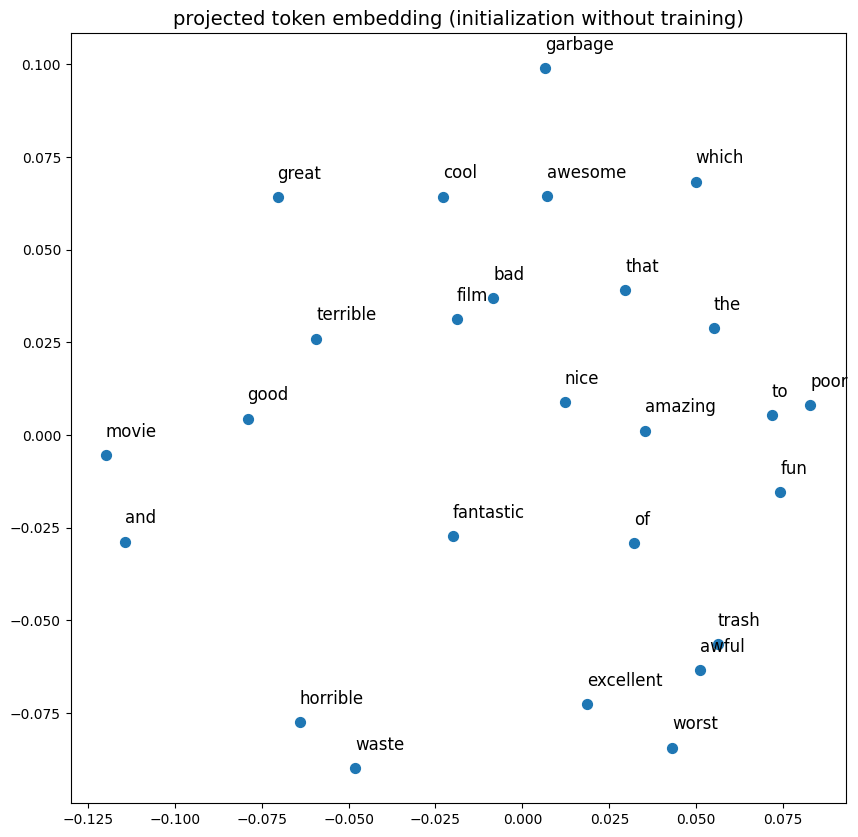

In [14]:
# project the high-dim embedding vectors onto a 2d plane
from sklearn.decomposition import PCA
emb_vec_init_pca = PCA(n_components=2).fit_transform(emb_vec_init)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(emb_vec_init_pca[:,0], emb_vec_init_pca[:,1], s=50)
for (x,y), w in zip(emb_vec_init_pca, words):
    plt.text(x, y+0.005, w, fontsize=12)
plt.title("projected token embedding (initialization without training)", fontsize=14)
plt.show()

You can see that the vectors are sort of randomly scattered now as the embedding layer is just randomly initialized without training. We will save these vectors now and later compare with those with the same word list after training to see what embedding will do for us.

We will train for only a few epochs, because the dataset is really small (total 50k corpuses in train/val/test) and hence very prone to overtraining.

In [ ]:
history = model.fit(x_train, y_train, batch_size=256, epochs=4, validation_data=(x_val, y_val))

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

Epoch 1/4
 24/149 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.5038 - loss: 0.6972

You see the val loss went up shortly after bottomed and but the train loss continued to drop, meaning the model was adjusting details/noises in the train set and not generalizing well on the val set. But OK lets see how it performs.

Coming back to the embedded tokens, we now retrieve from the trained embedding layer and plot the projected 2d vectors with the same word list.

In [ ]:
token_layer = model.get_layer(index=1).token_emb
token_w = token_layer.get_weights()[0]

print("embedding matrix shape:", token_w.shape)

words_idx = [word_to_index[word] + index_from for word in words]
emb_vec_trained = token_w[words_idx] # (len(words), embed_dim)

embedding matrix shape: (20000, 32)


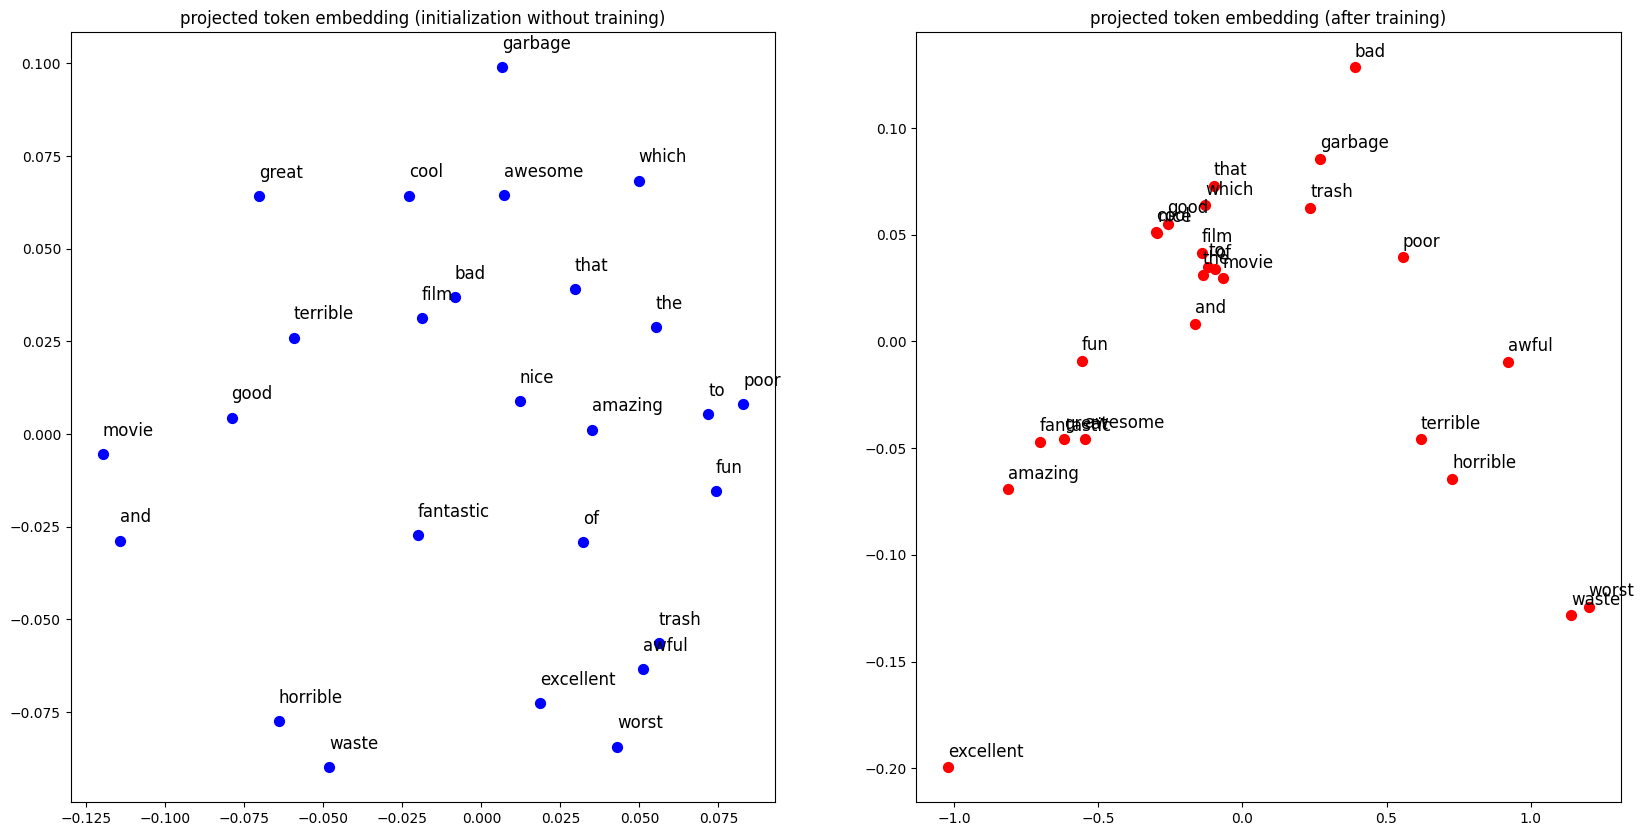

In [ ]:
emb_vec_trained_pca = PCA(n_components=2).fit_transform(emb_vec_trained)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(emb_vec_init_pca[:,0], emb_vec_init_pca[:,1], s=50, c='blue')
for (x, y), word in zip(emb_vec_init_pca, words):
    axes[0].text(x, y+0.005, word, fontsize=12)
axes[0].set_title("projected token embedding (initialization without training)")

axes[1].scatter(emb_vec_trained_pca[:,0], emb_vec_trained_pca[:,1], s=50, c='red')
for (x, y), word in zip(emb_vec_trained_pca, words):
    axes[1].text(x, y+0.005, word, fontsize=12)
axes[1].set_title("projected token embedding (after training)")

plt.show()

We can see that words with similar meaning are sort of clustered, especially the sentimental words, where the positive ones (awesome, excellent, etc) are on the right and the negative ones (worst, awful, etc) are on the left. Also the non-sentimental words (to, of, the, etc) are in the middle between the two.

Also note that these are condensed visualization because the embedding vectors are projected from ``{embed_dim}=32`` onto a 2d plane.

Recall that before the embedding layer, each word is tokenized by a unique integer without encoding any real information about the word itself. In the IMDB dataset, the integer is assigned according to the appearance frequency in the dataset. You can have say "good"=30 and "think"=31 and "excellent"=60, because neural networks only see numbers, does it make sense that "good" and "think" should have a similar representation but "good" and "excellent" should be far apart? Therefore the embedding layer is needed to learn the meaning in the fly, which builds vector space for the tokens and learn to encode information from the dataset. This way words with similar meaning should be similarly represented in the vector space, while words with very different meaning should be far apart.

The embedding should be thought of the first layer of understanding at a per-token level, while the content extraction is being done by the transformer encoder, and finally the sentiment judgement is being done by the downstream classifer.

Now lets take a look at a few examples from the test set and see how the model predicts their sentiment (output is probability of a positive review).

In [ ]:
y_pred = model.predict(x_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


In [ ]:
# print results for shortest sequences
zero_counts = np.sum(x_test==0, axis=1)
top_idx = np.argsort(zero_counts)[-20:][::-1].tolist()

for idx in top_idx:
    decoded_sequence = sequence_decoding(index_to_word, x_test[idx], ignore_pad=True)
    print(f"decoded x_test[{idx}] (y_true={y_test[idx]}, y_pred={y_pred[idx][0]}):\n" + textwrap.fill(decoded_sequence, width=120) + "\n")

decoded x_test[3204] (y_true=0, y_pred=0.14898383617401123):
primary plot primary direction poor interpretation

decoded x_test[1525] (y_true=1, y_pred=0.7635947465896606):
just love the interplay between two great characters of stage screen veidt barrymore

decoded x_test[3502] (y_true=1, y_pred=0.8003720641136169):
a mesmerizing film that certainly keeps your attention ben daniels is fascinating and courageous to watch

decoded x_test[470] (y_true=1, y_pred=0.8526656031608582):
add this little gem to your list of holiday regulars it is br br sweet funny and endearing

decoded x_test[5452] (y_true=1, y_pred=0.6144930720329285):
this is a good film this is very funny yet after this film there were no good ernest films

decoded x_test[2700] (y_true=1, y_pred=0.8913333415985107):
one of the funniest movies made in recent years good characterization plot and exceptional chemistry make this one a
classic

decoded x_test[2551] (y_true=0, y_pred=0.1805904656648636):
ten minutes of people spe

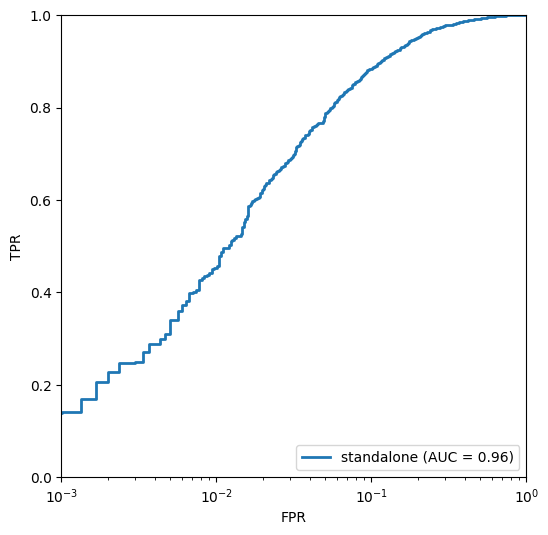

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(y_pred_dict, y_true):
    plt.figure(figsize=(6, 6))
    for name, y_pred in y_pred_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        model_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,
                 linestyle='-',
                 linewidth=2,
                 label=f'{name} (AUC = {model_auc:.2f})')
    
    plt.xlim(0.001, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='lower right')
    plt.xscale('log')
    plt.show()

plot_roc({'standalone':y_pred}, y_test)

Not bad!

We will also take a look at the attention to visualize how each word is attended to every words in a corpus.

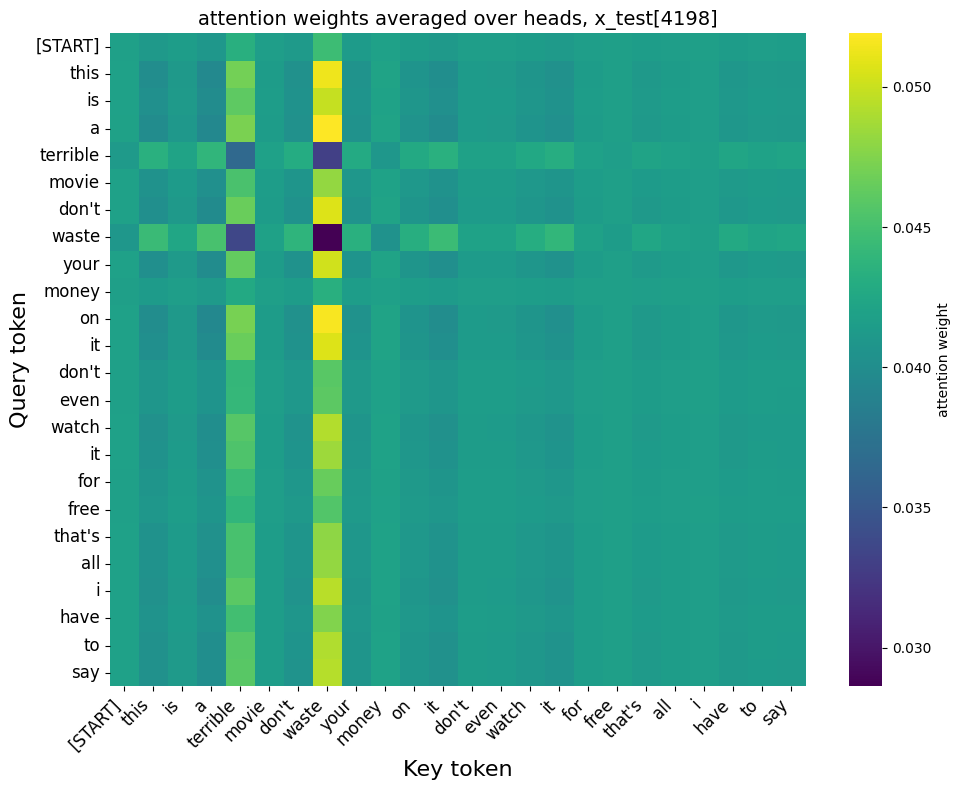

In [ ]:
import seaborn as sns
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Model

# pick an example from the test set and extract its attention outputs
seq_idx = 4198

# rebuild the exact same model up to the attention layer
x_in  = model.input # (batch, maxlen)
x_emb  = model.layers[1](x_in) # (batch, maxlen, embed_dim)

att_layer = model.layers[2].att

# create a mask (True to keep) to ignore the zero-padded tokens when passed to the attention layer
mask = Lambda(lambda t: tf.cast(tf.math.not_equal(t, 0), tf.int32), name="pad_mask")(x_in) # (batch, maxlen)

# att_output (batch, maxlen, embed_dim): output of after concatenation of heads
# att_scores (batch, heads, query_len, key_len): attention weights after softmax per head
att_output, att_scores = att_layer(
    x_emb, x_emb,
    attention_mask=mask,
    return_attention_scores=True,
    training=False
)

att_model = Model(x_in, att_scores, name="att_extractor")


test_seq = x_test[seq_idx:seq_idx+1] # (1, maxlen) to be passed to model
# att_matrix (heads, maxlen, maxlen): how much does each query attend to each key per head
# basically the softmax(QK^T/sqrt(d)) maxtrix
att_matrix = att_model.predict(test_seq, verbose=0)[0] # (head, maxlen, maxlen)

tokens = x_test[seq_idx] # (maxlen)

nonpad = np.where(tokens!=0)[0] # positions that are not padded
words = [index_to_word.get(int(t), "[UNK]") for t in tokens[nonpad]]
att_matrix = att_matrix[:, nonpad][:, :, nonpad] # get entries for non padded positions

# take average over heads
att_matrix_mean = att_matrix.mean(axis=0)

plt.figure(figsize=(10,8))
sns.heatmap(
    att_matrix_mean,
    xticklabels=words,
    yticklabels=words,
    cmap="viridis",
    cbar_kws={'label':'attention weight'}
)
plt.title(f"attention weights averaged over heads, x_test[{seq_idx}]", fontsize=14)
plt.xlabel("Key token", fontsize=16)
plt.ylabel("Query token",fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

This is plotting the ``softmax(QK^T/sqrt(d_k))`` matrix (the weights to be applied to the value matrix V), ignoring padded tokens and averaging over heads, meaning how much does each query token is attended to each key token in a corpus. Recall that query is what's doing the attending, key is what's being attended to, and value is what gets returned in an attention module.

Take this attention plot with a grain of salt, because both the dataset (O(10k) training examples and O(100k) model parameters) and the model are really tiny, and we only trained for less than 5 epochs to avoid overtraining.
The vectical axis shows the query tokens and the horizontal axis shows the key tokens. The heatmap intensity shows the attention score. Note the attention is averaged over all heads, and the average is computed with the padding tokens removed. In this example, the keys "terrible" and "wasted" are most attended, as they representative of the corpus sentiment. 

Next we will load a slightly larger transformer model pretrained by Google and fine tune it on the same IMDB dataset to see how it compares with the standalone transformer we trained above.

We will load Google's pretrained BERT model called ``bert_uncased_L-2_H-128_A-2`` from [HuggingFace](https://huggingface.co/google/bert_uncased_L-2_H-128_A-2), [1908.08962](https://arxiv.org/abs/1908.08962).
BERT stands for Bi-directional Encoder Representation from Transformers [1810.04805](https://arxiv.org/abs/1810.04805). Each BERT model is basically a transformer encoder stack, pretrained on a huge amount of corpuses with self-supervised and general tasks (missing word prediction and next sentence prediction) to learn the token embedding and basic language understanding. These pretrained models can then serve as a task-agnostic foundation with language knowledge encoded and to be connected to a task-specific downstream model like a classifier and fine tune for a specific task.
The pretrained model ``bert_uncased_L-2_H-128_A-2`` we are going to load is a tiny BERT with only ~4M parameters. It has 2 layers of transformer blocks (``L-2``), the multi-head attention module in each block contains two attention heads (``A-2``), and each word token is embedded into a hidden representation by a 128d vector (``H-128``).

We will see that this tiny BERT is already powerful enough compared to the standalone transformer we had above, due to a larger model size with a pretrained knowledge base. Now lets load it.

In [ ]:
# for demo lets fix a random seed to get reproducible initialization and results
import os
import random
os.environ['PYTHONHASHSEED'] = str(123)
random.seed(123)
tf.random.set_seed(123)
np.random.seed(123)

# !pip install transformers
from transformers import AutoConfig, AutoTokenizer, TFAutoModelForSequenceClassification

model_bert_name = "google/bert_uncased_L-2_H-128_A-2"
max_len = 200

# num_labels=2 instead of 1 here though it is a binary class, so one label for positive and another for negative.
# this is the default setup from the loaded model, so we don't need to manually add softmax to the output if setting num_labels=1.
config = AutoConfig.from_pretrained(model_bert_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_bert_name)
model_bert = TFAutoModelForSequenceClassification.from_pretrained(model_bert_name, config=config)

# we will allow the pretrained encoder to be trainable when fine tuning on IMDB
model_bert.trainable = True

model_bert.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
tf.keras.backend.set_value(model_bert.optimizer.learning_rate, 1.5e-4)

print(model_bert.config)
print(model_bert.summary())

/Users/hofungtsoi/miniforge3/envs/transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  4385920   
                                                                 
 dropout_7 (Dropout)         multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple

Lets see the token embedding, which has already been pretrained, so we should see some reasonable clustering.

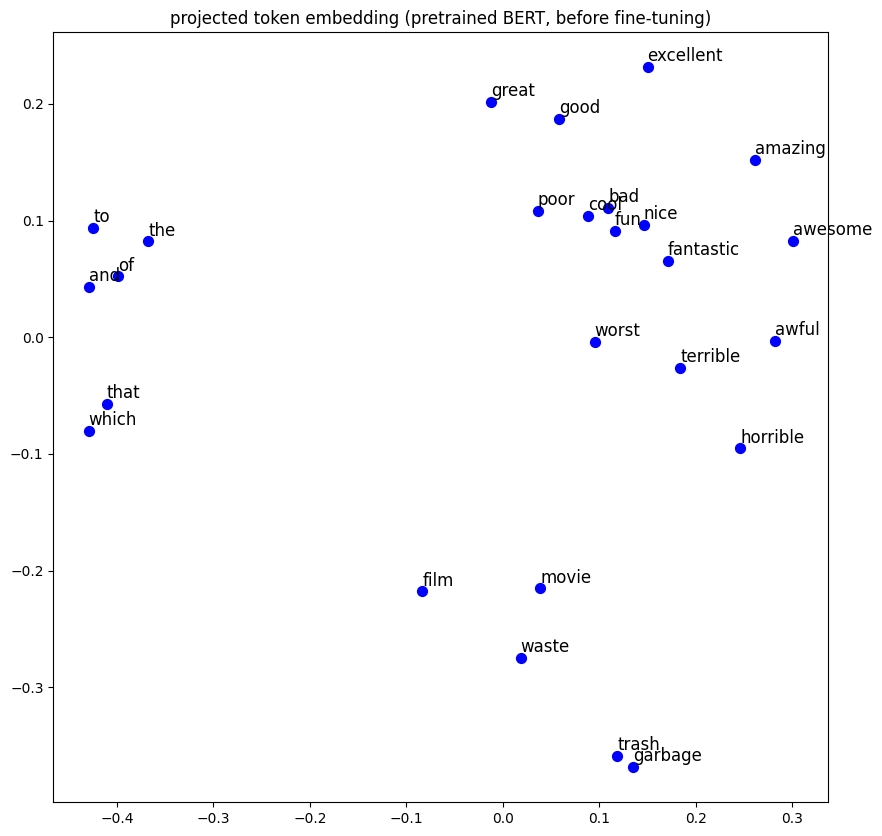

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

token_layer = model_bert.get_input_embeddings()
token_w = token_layer.weights[0].numpy() # (num_words, embed_dim)

words = [
    "good", "excellent", "great", "cool", "nice", "awesome", "amazing", "fantastic", "fun",
    "bad",  "worst", "awful", "terrible", "trash", "garbage", "waste", "poor", "horrible",
    "movie", "film",
    "the", "and", "to", "of", "which", "that",
]

token_ids = []
for w in words:
    tok = tokenizer.tokenize(w)[0]
    token_ids.append(tokenizer.convert_tokens_to_ids(tok))

emb_vec_bert_init = token_w[token_ids]
emb_vec_bert_init_pca = PCA(n_components=2).fit_transform(emb_vec_bert_init)

plt.figure(figsize=(10, 10))
plt.scatter(emb_vec_bert_init_pca[:,0], emb_vec_bert_init_pca[:,1], s=50, c='blue')
for (x,y), word in zip(emb_vec_bert_init_pca, words):
    plt.text(x, y+0.005, word, fontsize=12)
plt.title("projected token embedding (pretrained BERT, before fine-tuning)")
plt.show()

Indeed and actually looks like a much more general embedding clustering! For example, sentimental words are clustered, with positive and negaive subdivided inside; physical objects are clustered; grammatical phrases are clustered. And these clusters are also more regionalized and farther from one another. This makes sense as the pretraining was done with a much larger model and on a much larger dataset. Also the pretraining was done on sort of more general tasks (self-supervised missing word prediction and next sentence prediction) which are neutral in sentiment/judgement. If we allow the pretrained BERT to be trainable when fine tuning on the IMDB sentiment classification, it would not be surprising to see the positive and negative words to be separated a bit in the embedding. Lets see if this is the case.

Before fine tuning, we need to convert the IMDB dataset (x_train etc) from tokens to actual words (IMDB uses its own tokenizer to preprocess the sequence already), since the loaded BERT takes sequences of word strings directly at input and does its own tokenization on the fly.

In [ ]:
import textwrap
def sequence_decoding(index_to_word, x, ignore_pad=False):
    words = []
    for token_id in x:
        word = index_to_word.get(int(token_id), "[UNK]")
        if ignore_pad and word == "[PAD]":
            continue
        if word == "[START]":
            continue
        if word == "[OOV]":
            word = "INVALID"
        words.append(word)
    return " ".join(words)

x_train_decoded = []
x_val_decoded = []
x_test_decoded = []
for j in range(x_train.shape[0]):
    x_train_decoded.append(sequence_decoding(index_to_word, x_train[j], ignore_pad=True))
for j in range(x_val.shape[0]):
    x_val_decoded.append(sequence_decoding(index_to_word, x_val[j], ignore_pad=True))
for j in range(x_test.shape[0]):
    x_test_decoded.append(sequence_decoding(index_to_word, x_test[j], ignore_pad=True))

print(textwrap.fill(x_train_decoded[0], width=120) + "\n")

and you could just imagine being there robert INVALID is an amazing actor and now the same being director INVALID father
came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty
remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released
for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so
sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations
to the two little boy's that played the INVALID of norman and paul they were just brilliant children are often left out
of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but
these children are amazing and should be praised for what they have done don't you think the whole story was so lovely
because it was true and was someone's lif

Now we use the dedicated tokenizer ``tokenizer = AutoTokenizer.from_pretrained(model_bert_name)`` for this tiny BERT model.

In [ ]:
def encode_texts(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=200,
        return_tensors="tf"
    )

train_enc = encode_texts(x_train_decoded)
val_enc = encode_texts(x_val_decoded)
test_enc = encode_texts(x_test_decoded)

The pretrained BERT assumes a dataset format for training.

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), y_train)).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((dict(val_enc), y_val)).batch(64)

Again the IMDB is small (O(10k) examples) while the tiny BERT has ~4M parameters, so lets train for 2 epochs only to prevent severe overtraining.

Epoch 1/2
594/594 [==============================] - 142s 235ms/step - loss: 0.3882 - accuracy: 0.8191 - val_loss: 0.2959 - val_accuracy: 0.8728
Epoch 2/2
594/594 [==============================] - 140s 235ms/step - loss: 0.2526 - accuracy: 0.8987 - val_loss: 0.2860 - val_accuracy: 0.8798


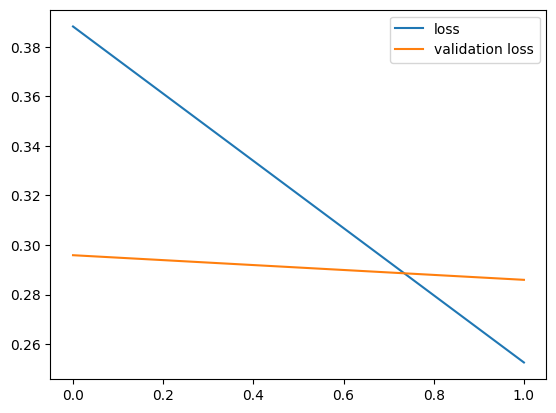

In [ ]:
history = model_bert.fit(train_ds, validation_data=val_ds, epochs=2)

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

In [ ]:
y_pred_bert_raw = model_bert.predict(test_enc) # TFSequenceClassifierOutput not array
y_pred_bert_raw = y_pred_bert_raw.logits # (n, 2)
print(y_pred_bert_raw[:5])

# convert the two output nodes into a single probability p(positive) using softmax
y_pred_bert = tf.nn.softmax(y_pred_bert_raw, axis=-1).numpy()[:, 1]
print(y_pred_bert[:5])


188/188 [==============================] - 13s 67ms/step
[[ 2.3224318  -2.4443963 ]
 [ 2.0982673  -2.2282186 ]
 [ 0.10796402 -0.20018367]
 [ 1.6307123  -1.8729256 ]
 [-1.7798358   1.7548116 ]]
[0.00843556 0.01304158 0.42356697 0.0292089  0.9716577 ]


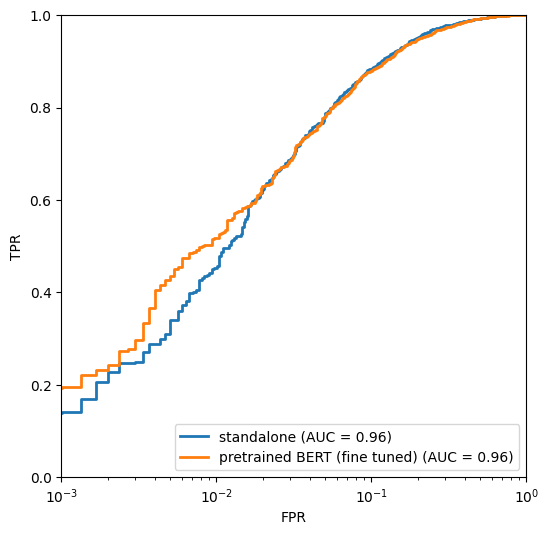

In [ ]:
plot_roc({'standalone':y_pred, 'pretrained BERT (fine tuned)':y_pred_bert}, y_test)

A marginal improvement seen though we only fine tuned for 2 epochs! Obviously we don't have time to run a bigger model or train for longer, but there are a few things you could play around with at free time:
- load a larger pretrained BERT (more transformer blocks, more heads, higher embedding dim etc)
- relax the {maxlen} and {num_words} constraints
- increase the downstream classifier model size (currently it goes from BERT embedding directly to the output without hidden layers)
- different fine-tuning strategies, e.g. let BERT trainable at early epochs then freeze it afterwards
- the IMDB dataset is tiny, which is prone to overfitting, so try on different larger datasets
- fine-tune for more epochs
- adjust other model and training parameters

We will next see that the model brings a richer embedding and a more contextual attention picture, compared to the standalone transformer we had.

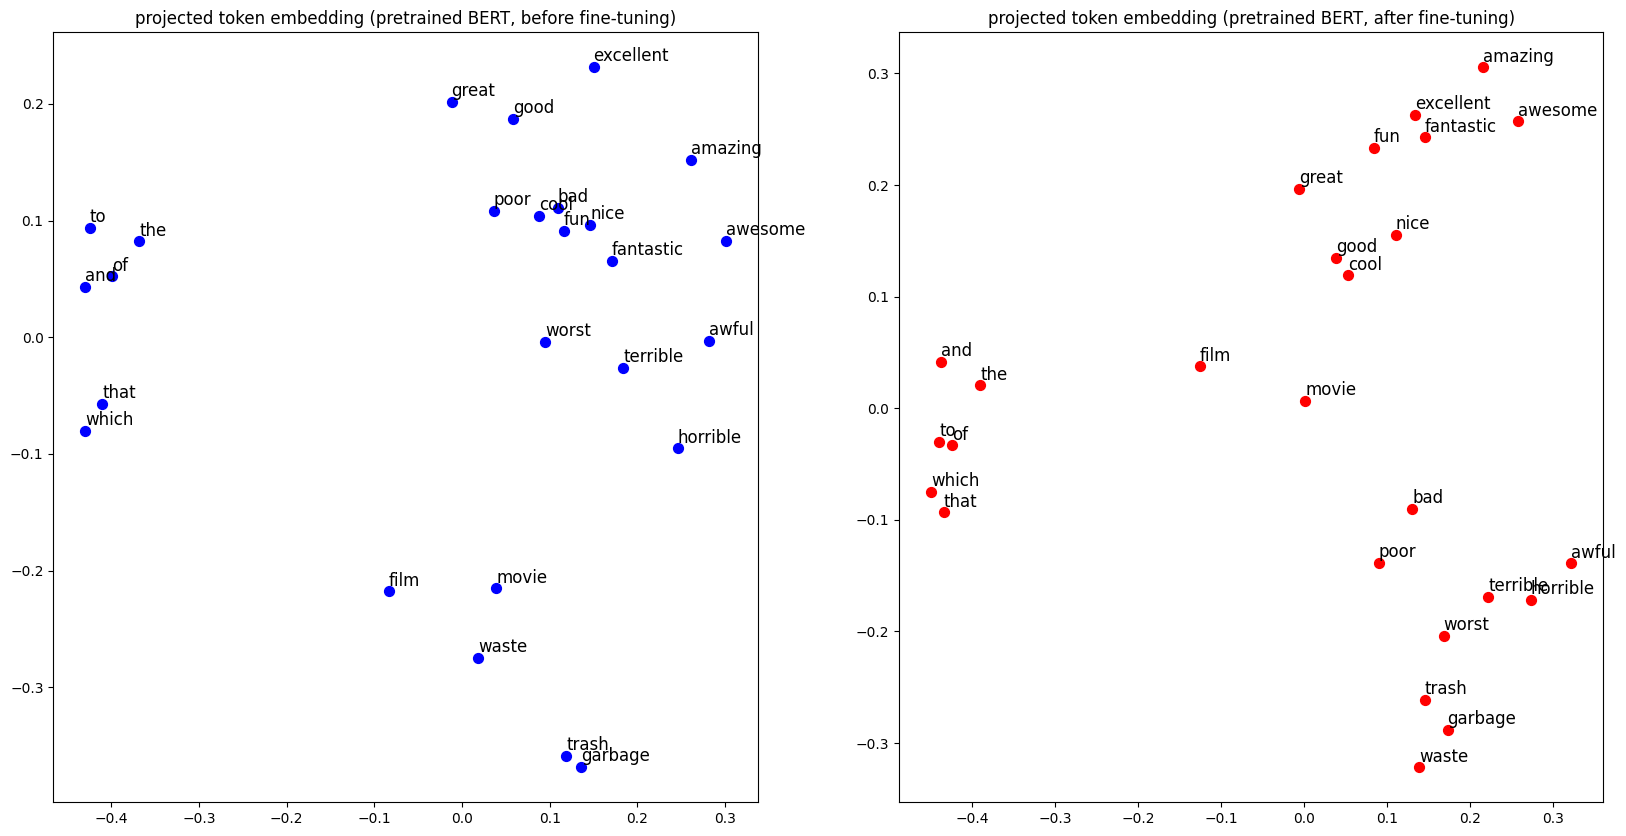

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

token_layer = model_bert.get_input_embeddings()
token_w = token_layer.weights[0].numpy() # (num_words, embed_dim)

words = [
    "good", "excellent", "great", "cool", "nice", "awesome", "amazing", "fantastic", "fun",
    "bad",  "worst", "awful", "terrible", "trash", "garbage", "waste", "poor", "horrible",
    "movie", "film",
    "the", "and", "to", "of", "which", "that",
]

token_ids = []
for w in words:
    tok = tokenizer.tokenize(w)[0]
    token_ids.append(tokenizer.convert_tokens_to_ids(tok))

emb_vec_bert_trained = token_w[token_ids]
emb_vec_bert_trained_pca = PCA(n_components=2).fit_transform(emb_vec_bert_trained)


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(emb_vec_bert_init_pca[:,0], emb_vec_bert_init_pca[:,1], s=50, c='blue')
for (x, y), word in zip(emb_vec_bert_init_pca, words):
    axes[0].text(x, y+0.005, word, fontsize=12)
axes[0].set_title("projected token embedding (pretrained BERT, before fine-tuning)")

axes[1].scatter(emb_vec_bert_trained_pca[:,0], emb_vec_bert_trained_pca[:,1], s=50, c='red')
for (x, y), word in zip(emb_vec_bert_trained_pca, words):
    axes[1].text(x, y+0.005, word, fontsize=12)
axes[1].set_title("projected token embedding (pretrained BERT, after fine-tuning)")

#plt.tight_layout()
plt.show()

wow, you can see the embedding is also fine-tuned to the IMDB dataset! The grammatical phrases haven't changed much as expected. The positive and negative words are now much more separated than before. In particular, you can see the words trash/garbage/waste that were previously more object-like rather than being sentimental in the embedding before fine-tuning, but now they are fine-tuned to be more sentimental as they live closer to other obvious negative words, since these words are more likely to appear in negative reviews and the embedding has learned that.

Now lets see how the embedding looks like.

In [ ]:
import seaborn as sns

model_bert.config.output_attentions = True

def plot_attention_heatmap(text, model_bert, layer, head=None):
    enc = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=maxlen,
        return_tensors="tf"
    )

    outputs = model_bert(
        {"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"]},
        training=False,
        return_dict=True
    )

    attentions = outputs.attentions  # (batch, heads, len_query, len_key)
    attn = attentions[layer][0].numpy()  # (heads, len_query, len_key)

    input_ids = enc["input_ids"][0].numpy()
    tokens_all = tokenizer.convert_ids_to_tokens(input_ids)

    token_mask = [tok not in ("[CLS]", "[SEP]", "[PAD]") for tok in tokens_all]
    tokens = [tok for tok, keep in zip(tokens_all, token_mask) if keep]

    if head is None:
        attn_matrix = attn.mean(axis=0) # mean over heads
    else:
        attn_matrix = attn[head] # single head

    attn_matrix = attn_matrix[np.ix_(token_mask, token_mask)]

    plt.figure(figsize=(10,8))
    sns.heatmap(
        attn_matrix,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="viridis",
        cbar_kws={'label': 'attention weight'}
    )
    if head is not None:
        plt.title(f"attention weights in head {head} (layer {layer})", fontsize=14)
    else:
        plt.title(f"attention weights averaged over heads (layer {layer})", fontsize=14)
    plt.xlabel("Key token", fontsize=16)
    plt.ylabel("Query token", fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

y_true=0, predicted prob=0.0075157699175179005


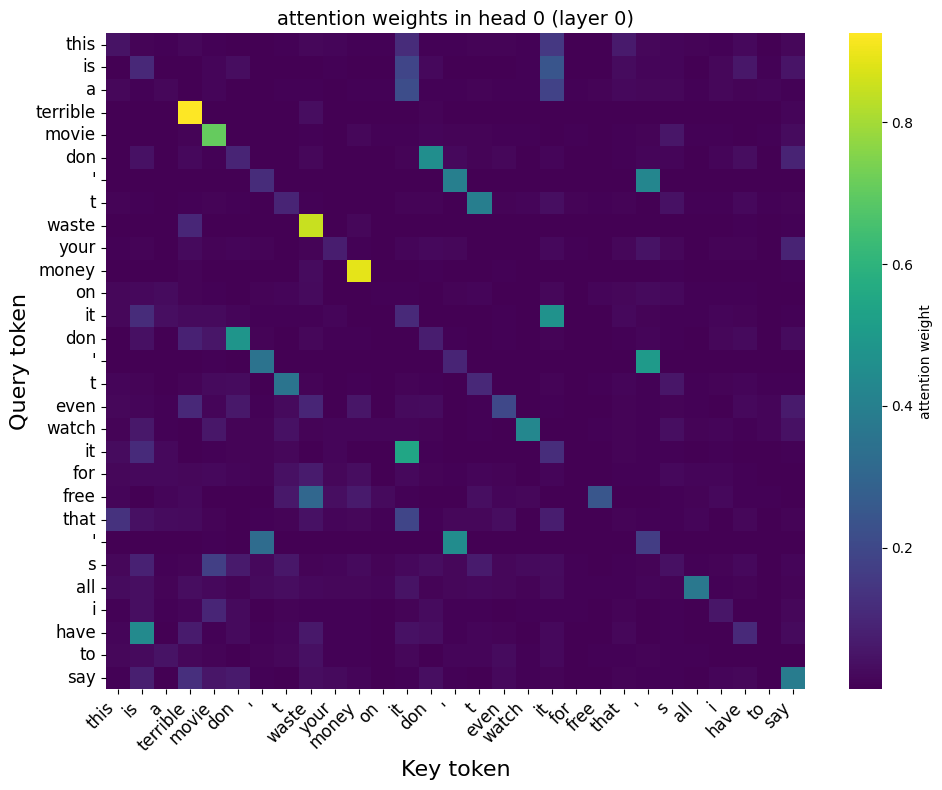

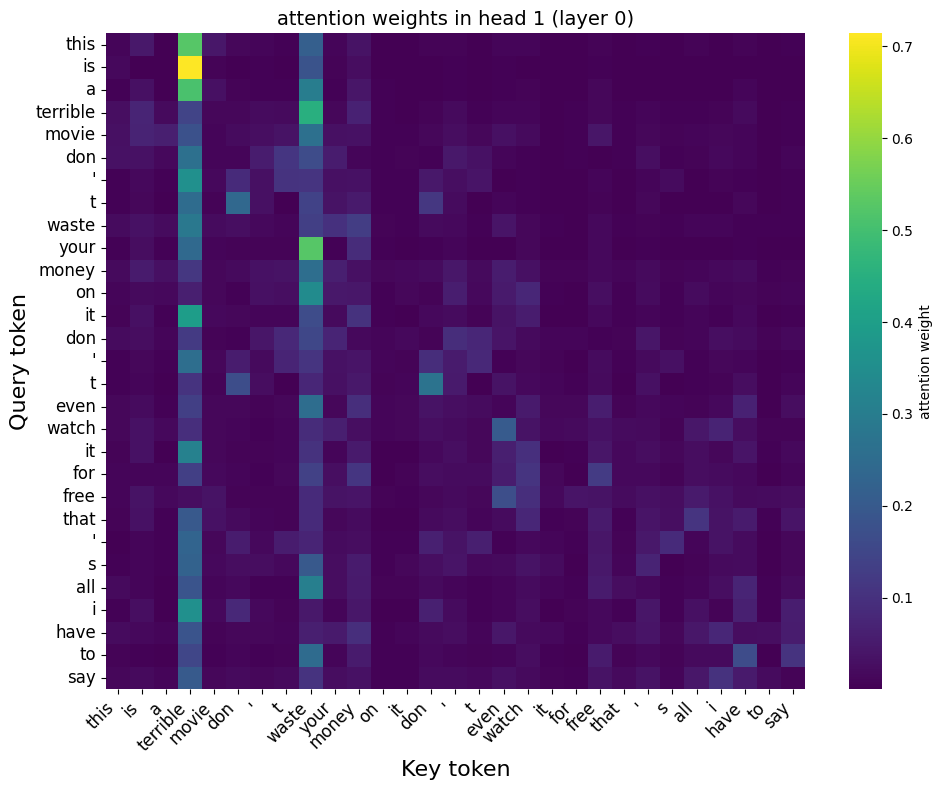

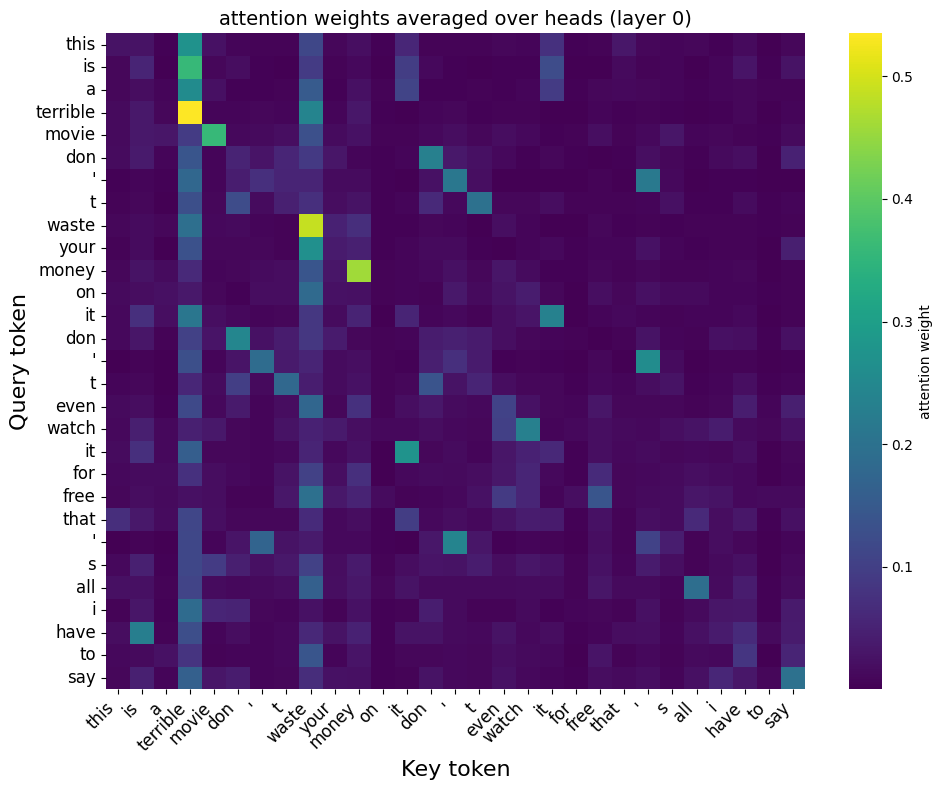

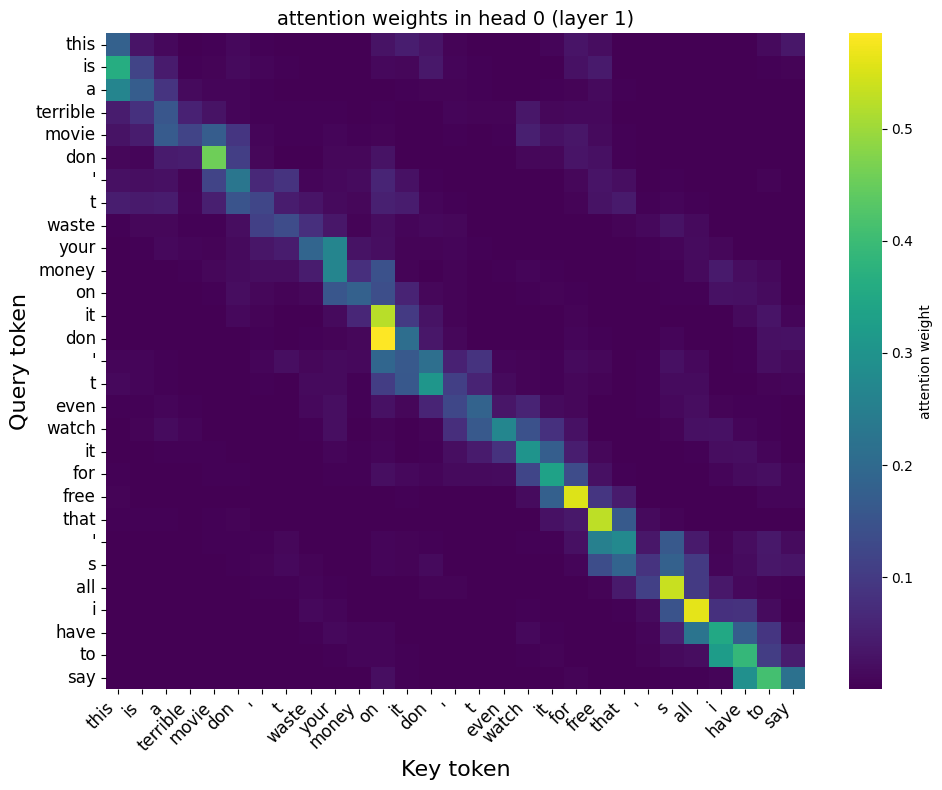

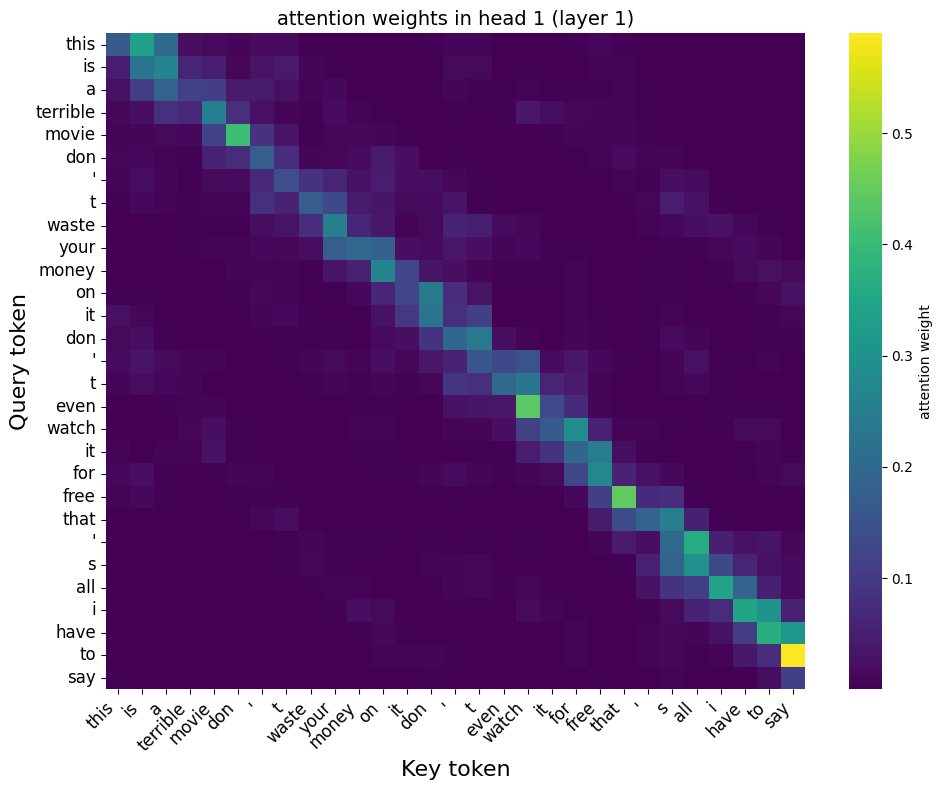

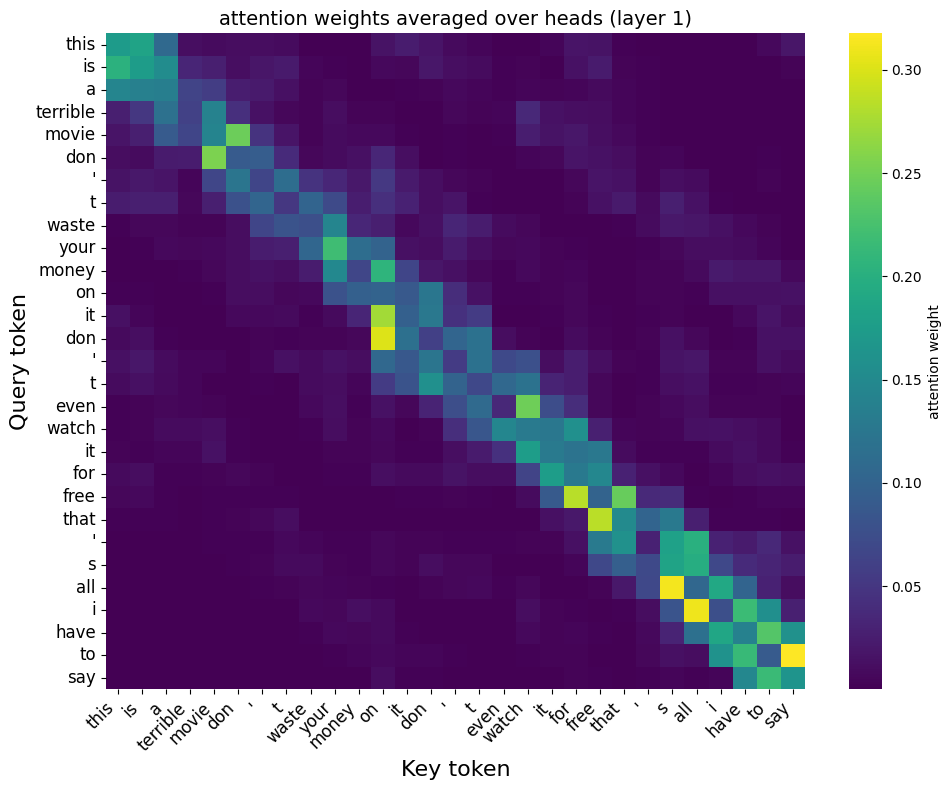

In [ ]:
idx=4198
print(f"y_true={y_test[idx]}, predicted prob={y_pred_bert[idx]}")
plot_attention_heatmap(x_test_decoded[idx], model_bert, layer=0, head=0)
plot_attention_heatmap(x_test_decoded[idx], model_bert, layer=0, head=1)
plot_attention_heatmap(x_test_decoded[idx], model_bert, layer=0, head=None)
plot_attention_heatmap(x_test_decoded[idx], model_bert, layer=1, head=0)
plot_attention_heatmap(x_test_decoded[idx], model_bert, layer=1, head=1)
plot_attention_heatmap(x_test_decoded[idx], model_bert, layer=1, head=None)

You might have noticed that this model treats "don't" as three separate tokens "don" + "'" + "t". This is how the loaded tokenizer works in its default setting. It might not be perfect in efficiency but should not affect the encoding capability significantly as I believe the model should be smart enough to learn to recognize such token combinations on the fly. For visualization, one could average the attention weights for "don" + "'" + "t" and take that as for "don't", to the first order, but fine for now.

So now, we see the attention weight matrix ``softmax(QK^T/sqrt(d_k))`` per head and also the average over heads in each transformer block. Recall that the tiny BERT we loaded is ``bert_uncased_L-2_H-128_A-2`` which has two transformer blocks (``L-2``), and two heads per multihead attention module (``A-2``), and each word token is embedded into a 128d vector space (``H-128``).

You can see that different transformer blocks are focused on extracting different contextual representations. In the example above, querys in the first block (layer 0) are mostly attended to sentimental cues like "terrible" and "waste", while those in the second block (layer 1) are systematically attended to nearby positions.

You can also write your own piece and see how the model reacts!

1/1 [==============================] - 0s 15ms/step
predicted prob=0.015015608631074429


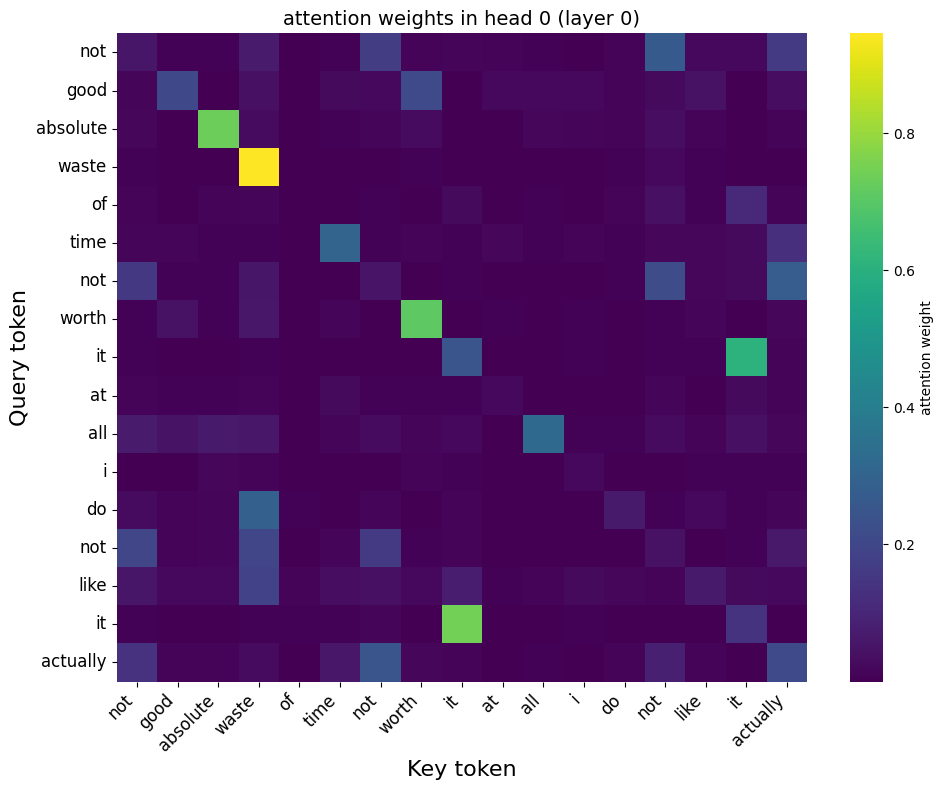

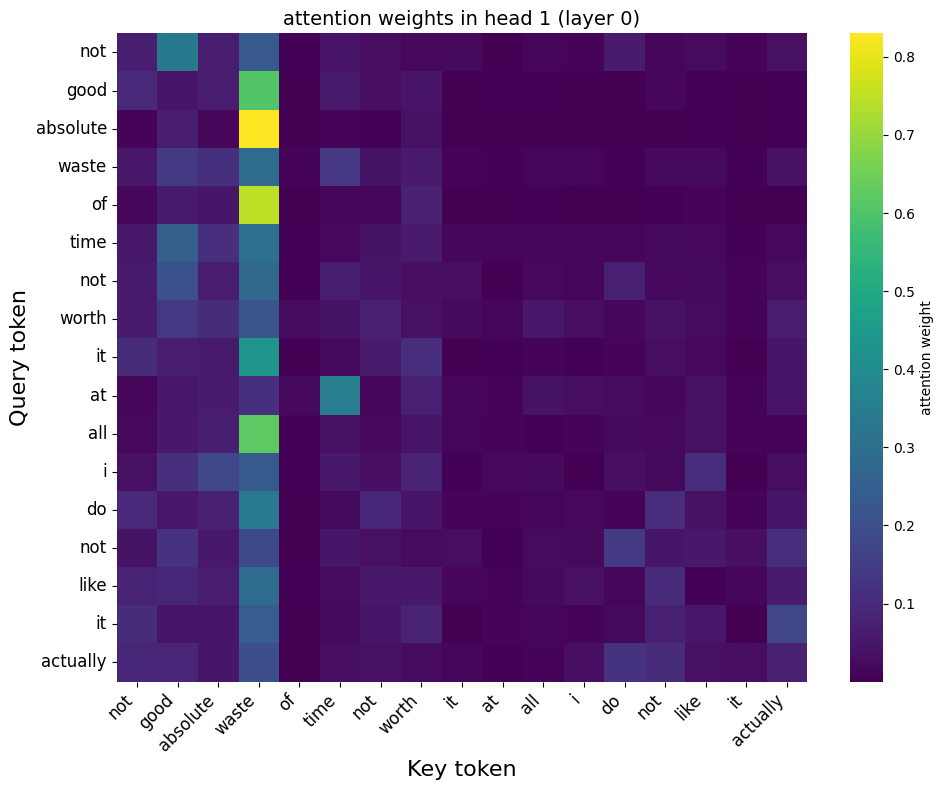

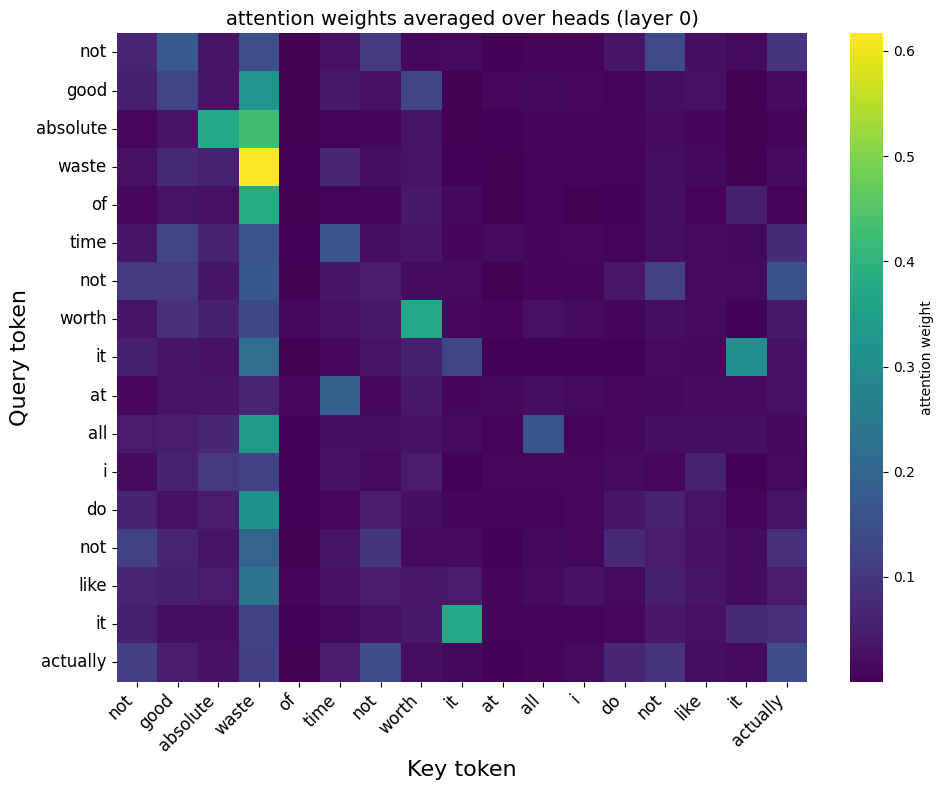

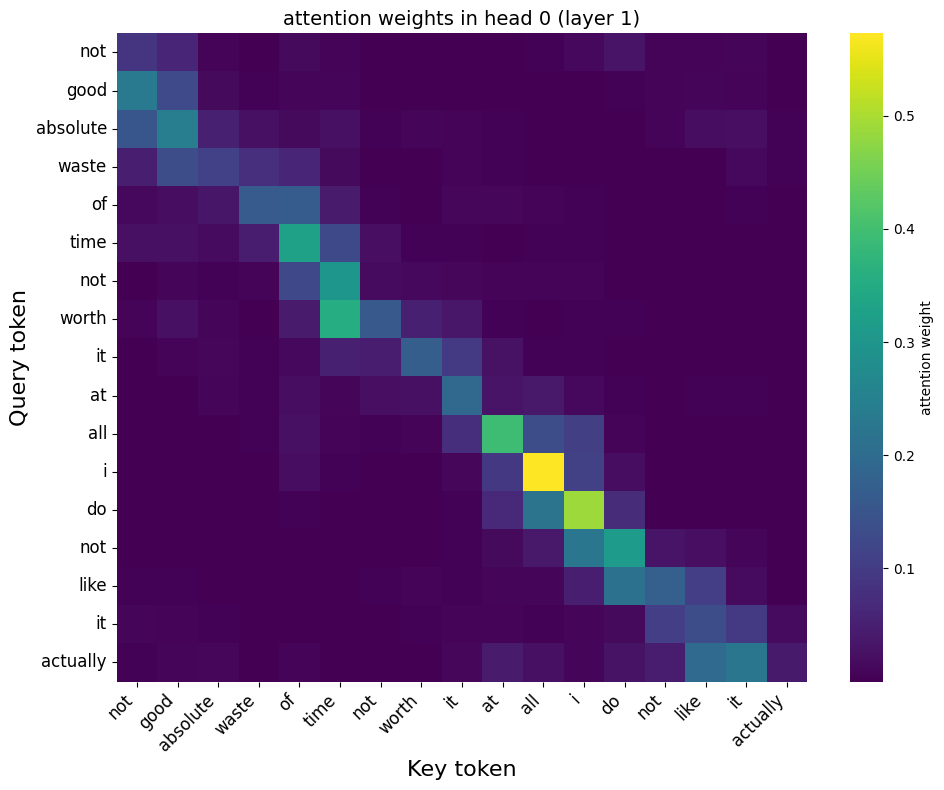

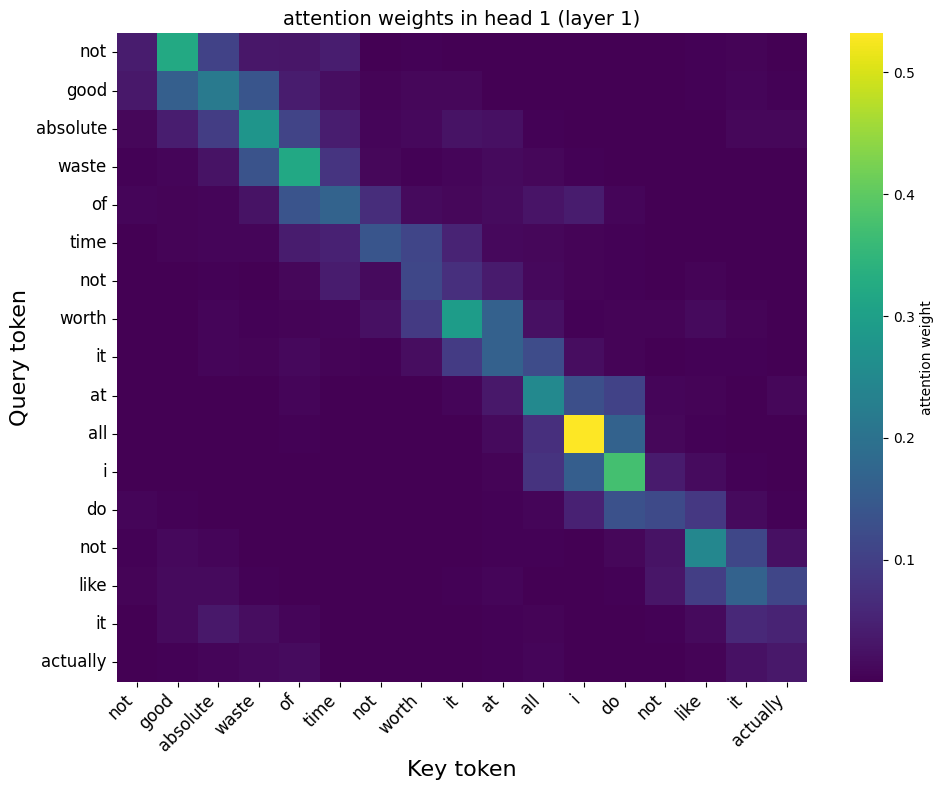

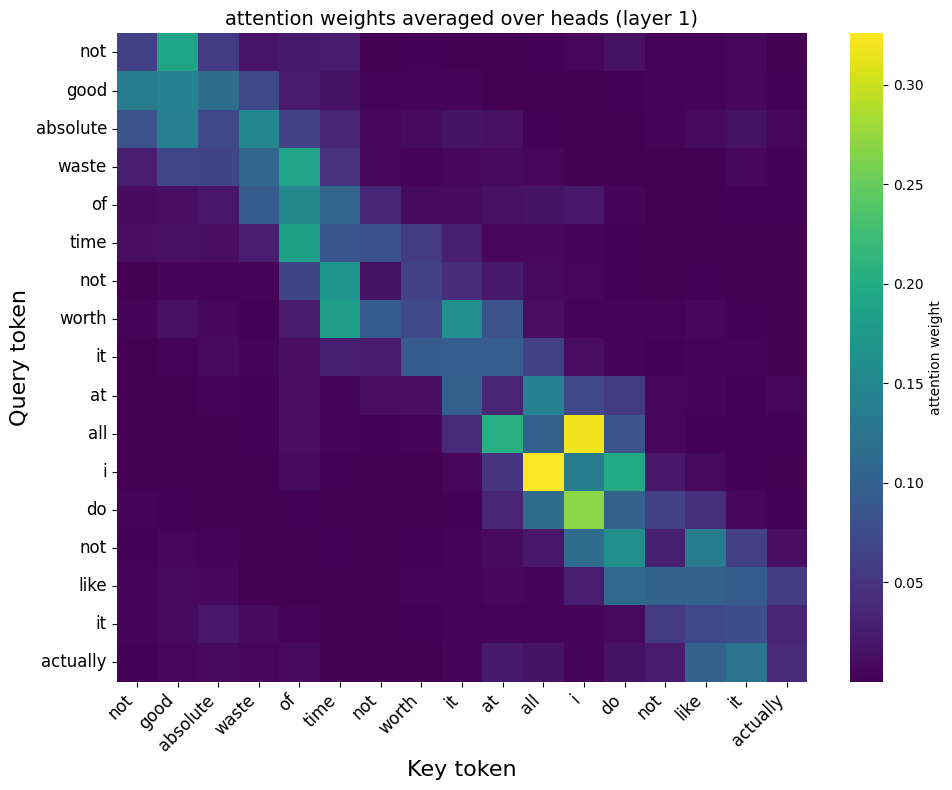

In [ ]:
mytext = "not good absolute waste of time not worth it at all i do not like it actually"
mytext_enc = encode_texts(mytext)
mytext_pred = tf.nn.softmax(model_bert.predict(mytext_enc).logits, axis=-1).numpy()[0,1]
print(f"predicted prob={mytext_pred}")
plot_attention_heatmap(mytext, model_bert, layer=0, head=0)
plot_attention_heatmap(mytext, model_bert, layer=0, head=1)
plot_attention_heatmap(mytext, model_bert, layer=0, head=None)
plot_attention_heatmap(mytext, model_bert, layer=1, head=0)
plot_attention_heatmap(mytext, model_bert, layer=1, head=1)
plot_attention_heatmap(mytext, model_bert, layer=1, head=None)

## demo: jet tagging in particle physics

If time allows, we will also run a simple transformer on the jetnet dataset from previous lectures.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size'] = 14
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from tensorflow.keras.models import Model

# for demo lets fix a random seed to get reproducible initialization and results
import os
import random
os.environ['PYTHONHASHSEED'] = str(123)
random.seed(123)
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
import h5py

qFile = h5py.File("q.hdf5", 'r')
qParts = qFile['particle_features'][:]
gFile = h5py.File("g.hdf5", 'r')
gParts = gFile['particle_features'][:]
wFile = h5py.File("w.hdf5", 'r')
wParts = wFile['particle_features'][:]
zFile = h5py.File("z.hdf5", 'r')
zParts = zFile['particle_features'][:]
tFile = h5py.File("t.hdf5", 'r')
tParts = tFile['particle_features'][:]

In [ ]:
parts = np.concatenate([qParts,gParts,wParts,zParts,tParts])
print('particle array shape:',parts.shape)
labels = np.concatenate([np.array([np.ones(qParts.shape[0])*(1. if i==0 else 0.) for i in range(5)]),
                         np.array([np.ones(gParts.shape[0])*(1. if i==1 else 0.) for i in range(5)]),
                         np.array([np.ones(wParts.shape[0])*(1. if i==2 else 0.) for i in range(5)]),
                         np.array([np.ones(zParts.shape[0])*(1. if i==3 else 0.) for i in range(5)]),
                         np.array([np.ones(tParts.shape[0])*(1. if i==4 else 0.) for i in range(5)])],axis=-1).T
print('label array shape:',labels.shape)

particle array shape: (880000, 30, 4)
label array shape: (880000, 5)


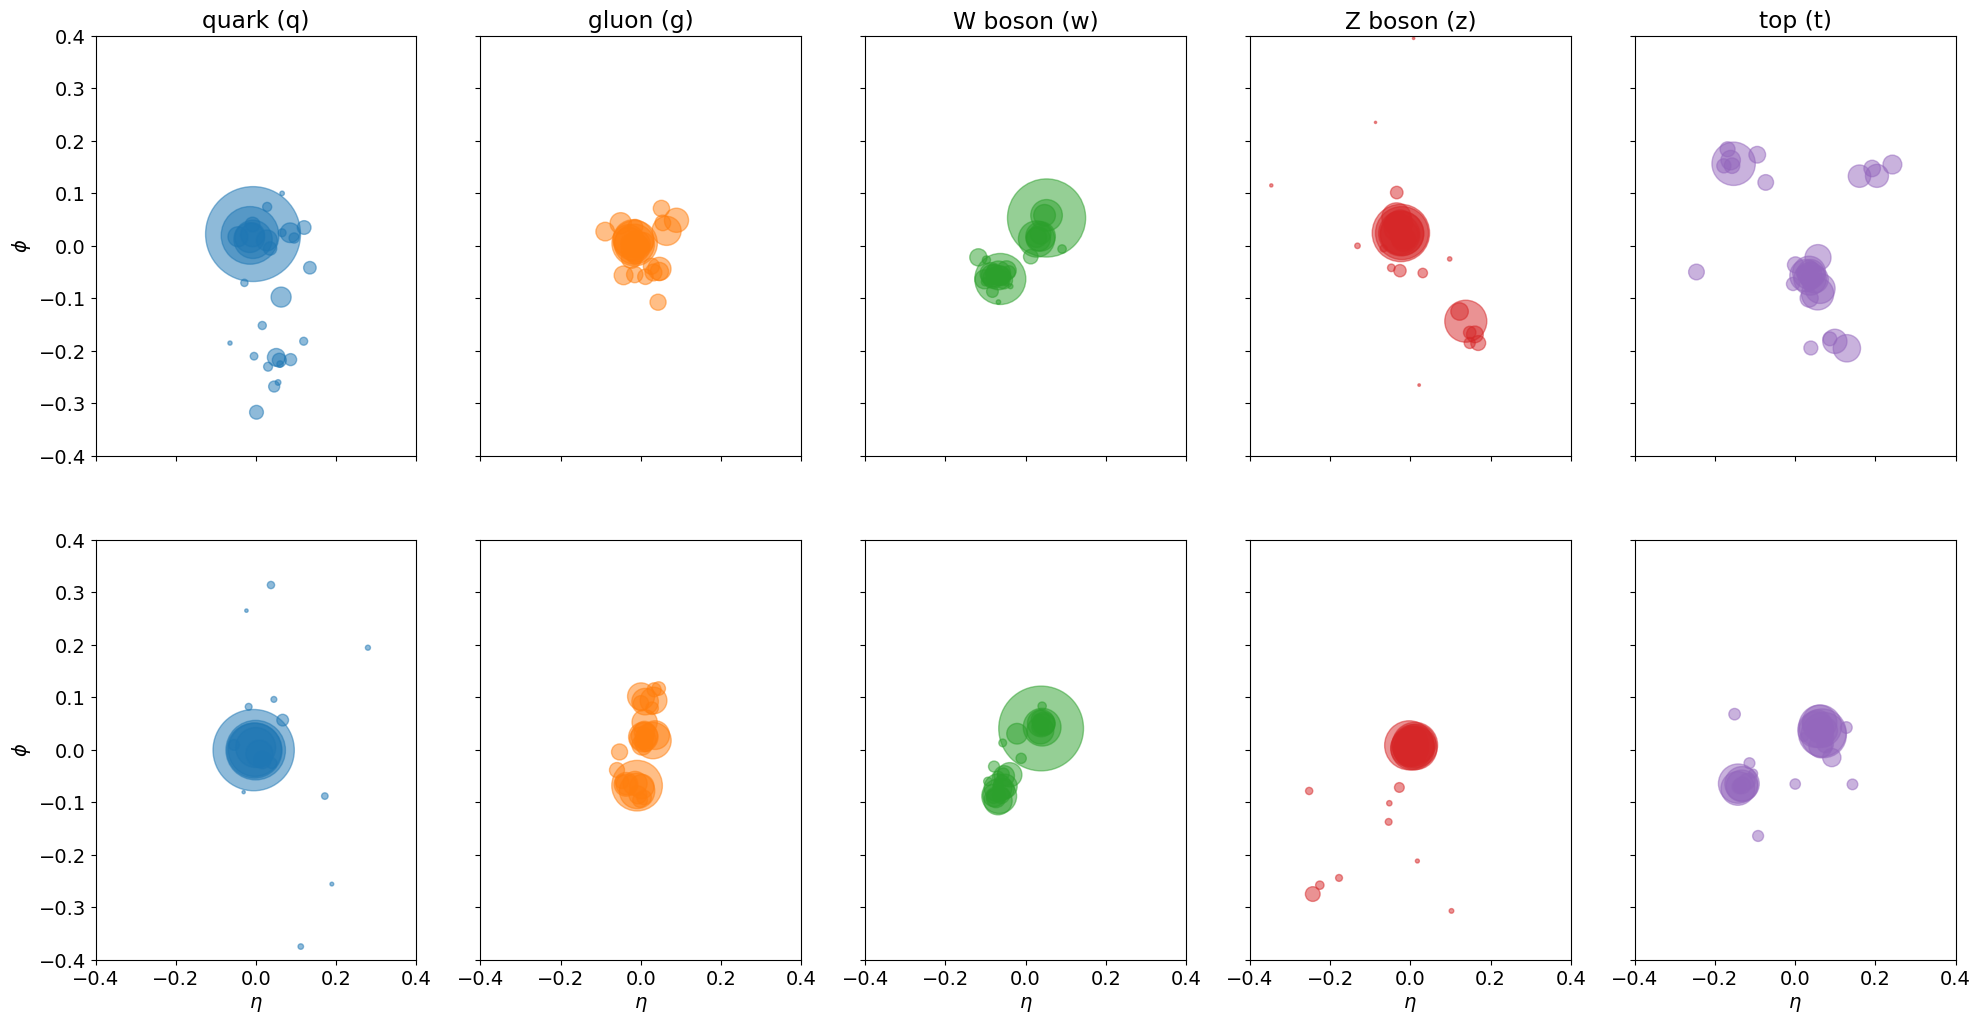

In [ ]:
iev = 0
fig,axs = plt.subplots(2,5,figsize=(24,12),sharex=True,sharey=True)
labelnames = ['quark (q)','gluon (g)','W boson (w)','Z boson (z)','top (t)']

for j in range(2):
    for i in range(5):
        axs[j,i].scatter(parts[labels[:,i]==1,:,0][iev+j],
                         parts[labels[:,i]==1,:,1][iev+j],
                         s=parts[labels[:,i]==1,:,2][iev+j]*10000.,alpha=0.5,color='C%i'%i)
        if j==0:
            axs[j,i].set_title(labelnames[i])
        if j==1:
            axs[j,i].set_xlabel(r'$\eta$')
        if i==0:
            axs[j,i].set_ylabel(r'$\phi$')
        axs[j,i].set_xlim(-0.4,0.4)
        axs[j,i].set_ylim(-0.4,0.4)

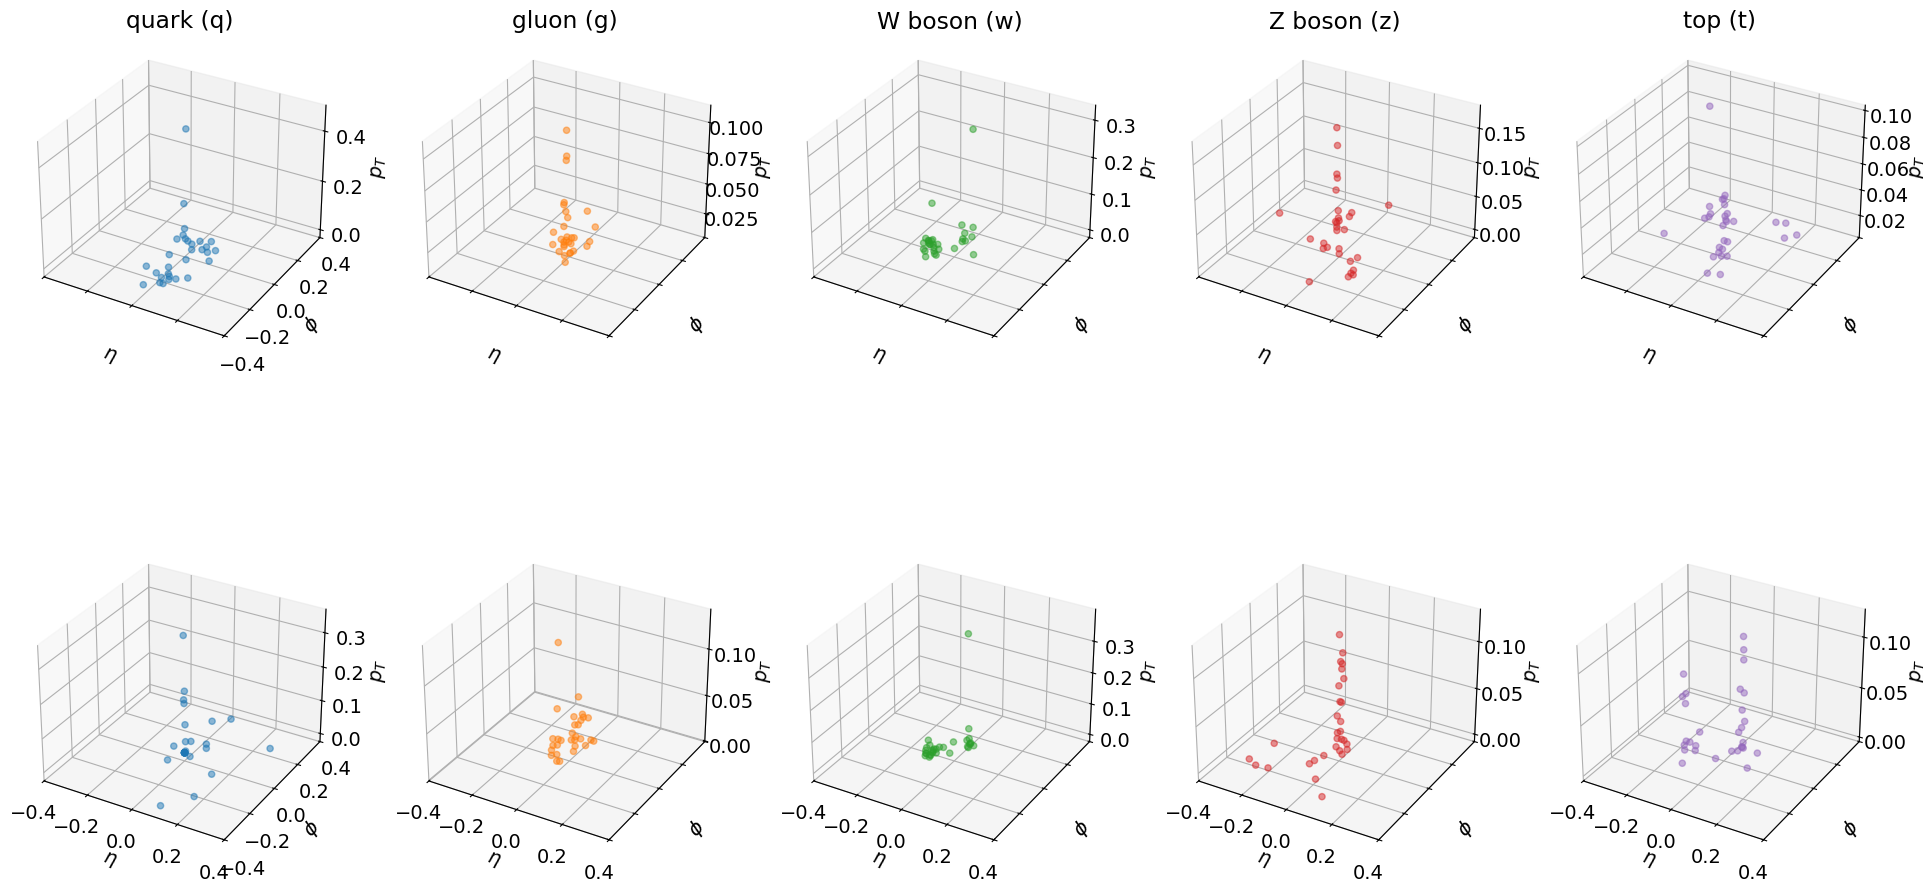

In [ ]:
iev = 0
fig,axs = plt.subplots(2,5,figsize=(24,12),sharex=True,sharey=True,subplot_kw={'projection':'3d'})
labelnames = ['quark (q)','gluon (g)','W boson (w)','Z boson (z)','top (t)']

for j in range(2):
    for i in range(5):
        axs[j,i].scatter(parts[labels[:,i]==1,:,0][iev+j],
                         parts[labels[:,i]==1,:,1][iev+j],
                         parts[labels[:,i]==1,:,2][iev+j],alpha=0.5,color='C%i'%i)
        if j==0:
            axs[j,i].set_title(labelnames[i])
        axs[j,i].set_xlabel(r'$\eta$')
        axs[j,i].set_ylabel(r'$\phi$')
        axs[j,i].set_zlabel(r'$p_T$')
        axs[j,i].set_xlim(-0.4,0.4)
        axs[j,i].set_ylim(-0.4,0.4)

Lets first train a GNN from the previous lecture for later comparison. We consider a small enough number of jet particles and a small model size for quick training.

In [ ]:
maxparts = 10
ntotal = parts.shape[0]
trainfrac = 0.6
valfrac = 0.2
p = np.random.permutation(ntotal)

parts_train = parts[p[:int(ntotal*trainfrac)],:maxparts]
labels_train = labels[p[:int(ntotal*trainfrac)]]
parts_valid = parts[p[int(ntotal*trainfrac):int(ntotal*(trainfrac+valfrac))],:maxparts]
labels_valid = labels[p[int(ntotal*trainfrac):int(ntotal*(trainfrac+valfrac))]]
parts_test = parts[p[int(ntotal*(trainfrac+valfrac)):],:maxparts]
labels_test = labels[p[int(ntotal*(trainfrac+valfrac)):]]

print(parts_train.shape)
print(parts_valid.shape)
print(parts_test.shape)

(528000, 10, 4)
(176000, 10, 4)
(176000, 10, 4)


In [ ]:
#from keras.layers import Input, Dense, BatchNormalization, Lambda, Concatenate, Dropout
#from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D

def jetnet_gnn(rdims=[32,32], odims=[32,32], cdims=[32,32], inv=True, particlesConsidered=maxparts,entriesPerParticle=parts_train.shape[-1]):
    # Defines the interaction matrices
    
    # Defines the recieving matrix for particles
    RR = []
    for i in range(particlesConsidered):
        row = []
        for j in range(particlesConsidered * (particlesConsidered - 1)):
            if j in range(i * (particlesConsidered - 1), (i + 1) * (particlesConsidered - 1)):
                row.append(1.0)
            else:
                row.append(0.0)
        RR.append(row)
    RR = np.array(RR)
    RR = np.float32(RR)
    RRT = np.transpose(RR)
    
    # Defines the sending matrix for particles
    RST = []
    for i in range(particlesConsidered):
        for j in range(particlesConsidered):
            row = []
            for k in range(particlesConsidered):
                if k == j:
                    row.append(1.0)
                else:
                    row.append(0.0)
            RST.append(row)
    rowsToRemove = []
    for i in range(particlesConsidered):
        rowsToRemove.append(i * (particlesConsidered + 1))
    RST = np.array(RST)
    RST = np.float32(RST)
    RST = np.delete(RST, rowsToRemove, 0)
    RS = np.transpose(RST)
    
    # Creates and trains the neural net
    
    inputs = Input(shape=(particlesConsidered,entriesPerParticle))
    
    XdotRR = Lambda(lambda tensor: tf.transpose(tf.tensordot(tf.transpose(tensor, perm=(0, 2, 1)), RR, axes=[[2], [0]]),
                                                perm=(0, 2, 1)), name="XdotRR")(inputs)
    XdotRS = Lambda(lambda tensor: tf.transpose(tf.tensordot(tf.transpose(tensor, perm=(0, 2, 1)), RS, axes=[[2], [0]]),
                                                perm=(0, 2, 1)), name="XdotRS")(inputs)
    Bpp = Concatenate(axis=2, name="Bpp")([XdotRR, XdotRS])

    x = Bpp
    for i,d in enumerate(rdims):
        if i==0:
            x = BatchNormalization()(x)
        if i==len(rdims)-1:
            #x = Dropout(0.1)(x)
            x = BatchNormalization()(x)
        x = Conv1D(d,1,1,activation='relu',name='fR%i'%(i+1))(x)
    
    Epp = BatchNormalization(name="Epp")(x)
    
    EppBar = Lambda(lambda tensor: tf.transpose(tf.tensordot(tf.transpose(tensor, perm=(0, 2, 1)), RRT, axes=[[2], [0]]),
                                                perm=(0, 2, 1)), name="EppBar")(Epp)
    C = Concatenate(axis=2)([inputs, EppBar])
    
    x = C
    for i,d in enumerate(odims):
        if i==0:
            x = BatchNormalization()(x)
        if i==len(odims)-1:
            #x = Dropout(0.1)(x)
            x = BatchNormalization()(x)
        x = Conv1D(d,1,1,activation='relu',name='fO%i'%(i+1))(x)
    O = x
    
    if inv:
        OBar = GlobalAveragePooling1D(name='OBar')(O)
    else:
        OBar = Flatten(name='OBar')(O)
    
    x = OBar
    for i,d in enumerate(cdims):
        x = Dense(d,activation='relu',name='phiC%i'%(i+1))(x)
        if i==0:
            x = BatchNormalization()(x)

    outputs = Dense(len(labelnames), activation="softmax",name='output')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="gnn")


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=5,
        restore_best_weights=True,
        min_delta=0.001, 
    )
reducelr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=1.e-7,
)

jetgnnmodel = jetnet_gnn([16,16],[16,16,64],[100,100,50],particlesConsidered=maxparts)

ntrain = 200000

print(jetgnnmodel.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=1e-3)
jetgnnmodel.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

history = jetgnnmodel.fit(parts_train[:ntrain], labels_train[:ntrain], batch_size=64, epochs=500, validation_data=(parts_valid,labels_valid), callbacks=(earlystop, reducelr))


Model: "gnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ XdotRR (Lambda)     │ (None, 90, 4)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ XdotRS (Lambda)     │ (None, 90, 4)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bpp (Concatenate)   │ (None, 90, 8)     │          0 │ XdotRR[0][0],     │
│                     │                   │            │ XdotRS[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 8)     │         32 │ Bpp[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fR1 (Conv1D)        │ (None, 90, 16)    │        144 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 16)    │         64 │ fR1[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fR2 (Conv1D)        │ (None, 90, 16)    │        272 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Epp                 │ (None, 90, 16)    │         64 │ fR2[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EppBar (Lambda)     │ (None, 10, 16)    │          0 │ Epp[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 20)    │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ EppBar[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 20)    │         80 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fO1 (Conv1D)        │ (None, 10, 16)    │        336 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fO2 (Conv1D)        │ (None, 10, 16)    │        272 │ fO1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 16)    │         64 │ fO2[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fO3 (Conv1D)        │ (None, 10, 64)    │      1,088 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OBar                │ (None, 64)        │          0 │ fO3[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ phiC1 (Dense)       │ (None, 100)       │      6,500 │ OBar[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ phiC1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ phiC2 (Dense)       │ (None, 100)       │     10,100 │ batch_normalizat

 Total params: 24,721 (96.57 KB)

 Trainable params: 24,369 (95.19 KB)

 Non-trainable params: 352 (1.38 KB)

None
Epoch 1/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.5648 - loss: 1.1045 - val_accuracy: 0.6317 - val_loss: 0.9730 - learning_rate: 0.0010
Epoch 2/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6143 - loss: 1.0023 - val_accuracy: 0.6411 - val_loss: 0.9541 - learning_rate: 0.0010
Epoch 3/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6261 - loss: 0.9818 - val_accuracy: 0.6432 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 4/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6342 - loss: 0.9662 - val_accuracy: 0.6485 - val_loss: 0.9336 - learning_rate: 0.0010
Epoch 5/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6399 - loss: 0.9549 - val_accuracy: 0.6554 - val_loss: 0.9237 - learning_rate: 0.0010
Epoch 6/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6434 - loss: 0.9458 - val_accuracy: 0.6598 - val_loss: 0.9159 - learning_rate: 0.0010
Epoch 7/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - a

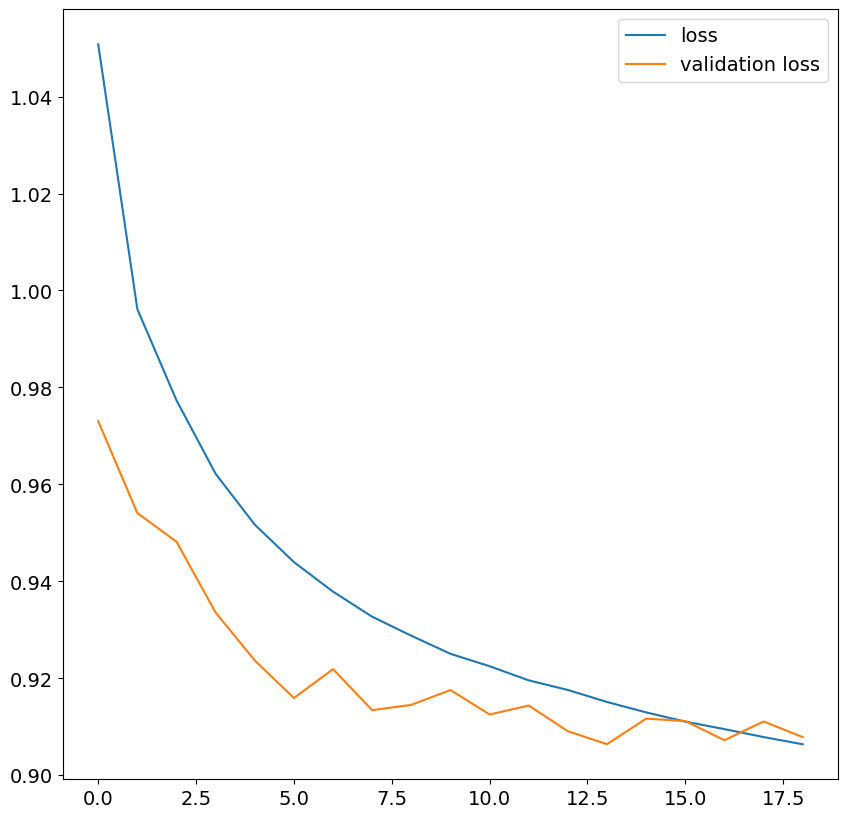

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

In [ ]:
predjetgnn_ytrain = jetgnnmodel.predict(parts_train)
predjetgnn_yvalid = jetgnnmodel.predict(parts_valid)
predjetgnn_ytest = jetgnnmodel.predict(parts_test)

16500/16500 ━━━━━━━━━━━━━━━━━━━━ 14s 828us/step
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 5s 826us/step
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 4s 783us/step


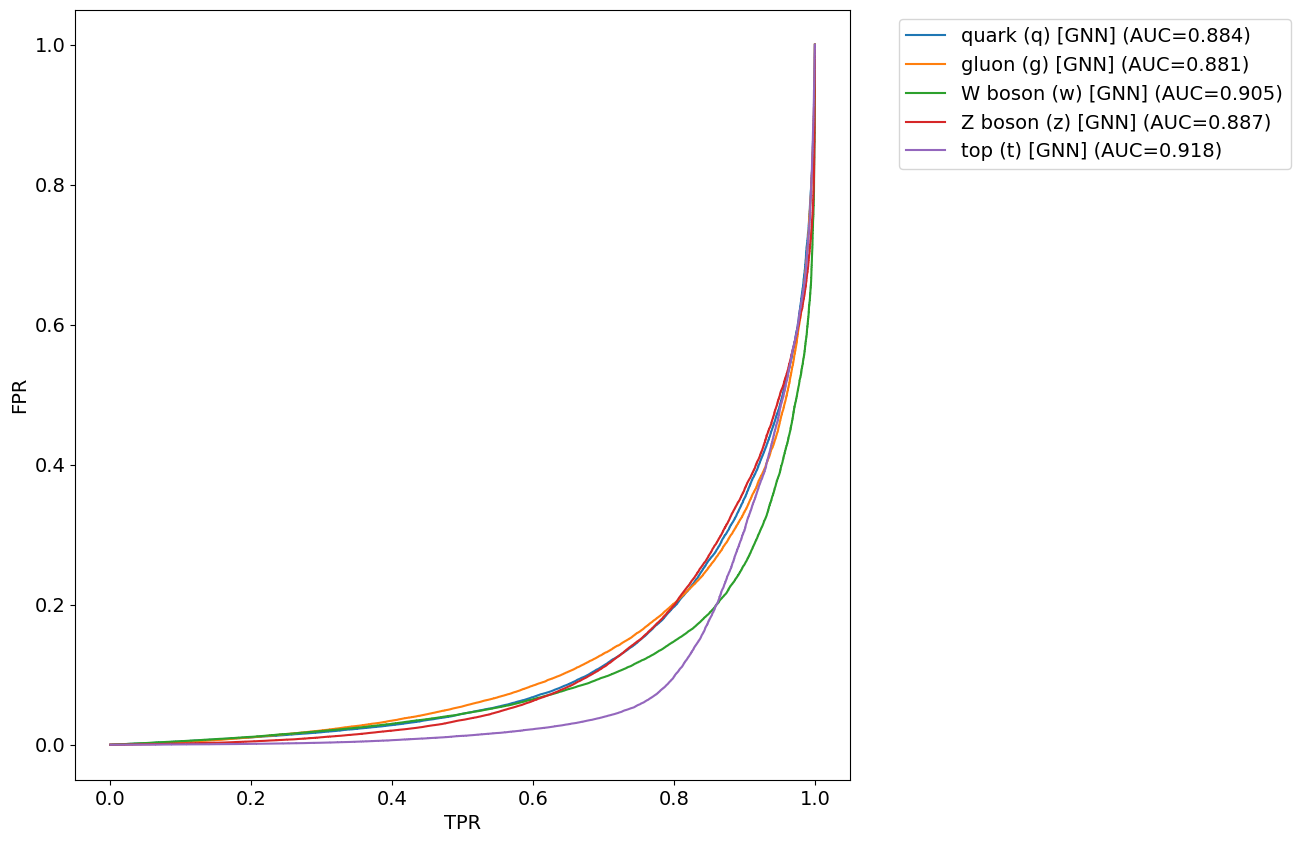

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

def plot_jetnet_roc(ysel_test,pred_ytests,log=True):
    for i in range(len(labelnames)):
        for j, alg in enumerate(pred_ytests):
            fpr, tpr, thresholds = roc_curve(ysel_test[alg][:,i] if isinstance(ysel_test, dict) else ysel_test[:,i], pred_ytests[alg][:,i])
            auc = roc_auc_score(ysel_test[alg][:,i] if isinstance(ysel_test, dict) else ysel_test[:,i], pred_ytests[alg][:,i])
            plt.plot(tpr,fpr, label='%s [%s] (AUC=%.3f)'%(labelnames[i],alg,auc),color='C%i'%i,linestyle=['solid','dashed','dotted','dashdot'][j])
    
    if log:
        plt.yscale('log')

    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.legend(bbox_to_anchor=(1.05, 1))

plot_jetnet_roc(labels_test,
                 {'GNN':predjetgnn_ytest},
                 log=False)

The above just reproduces one of the gnn results from the previous lecture, lets look at how transformer does in the following.

We will create a simple transformer model that has ~same number of parameters as the gnn above. Recall that transformer block is permutation-invariant as discussed earlier, and we should not add positional embedding as we did for text processing.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ffn_dim, rate=0.1, **kw):
        super().__init__(**kw)
        self.attn = MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([Dense(ffn_dim, activation='relu'), Dense(embed_dim)])
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x):
        attn_output = self.attn(x, x)
        attn_output = self.layernorm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(attn_output)
        return self.layernorm2(attn_output + self.dropout2(ffn_output))

def jet_transformer(
    particles=maxparts,
    in_features=4,
    embed_dim=18,
    num_heads=3,
    ffn_dim=64,
    num_layers=3,
    classifier_dim=[80, 40],
    num_classes=5,
    dropout_rate=0.1):

    x_in = Input(shape=(particles, in_features), name='jet_input')

    # particle embedding
    x = Dense(embed_dim, activation='relu', name='input_proj')(x_in)

    # permutation‑equivariant transformer encoders
    for i in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ffn_dim, dropout_rate, name=f'Transformer_{i}')(x)

    # permutation‑invariant pooling
    x = GlobalAveragePooling1D(name='set_mean')(x)

    # jet‑level classifier
    for i, units in enumerate(classifier_dim):
        x = Dense(units, activation='relu', name=f'cls_dense_{i}')(x)
        if i == 0:
            x = BatchNormalization()(x)

    x = Dense(num_classes, activation='softmax', name='output')(x)

    return Model(inputs=x_in, outputs=x, name='JetTransformer')


jettransformermodel=jet_transformer()
print(jettransformermodel.summary())

Model: "JetTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ jet_input (InputLayer)          │ (None, 10, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_proj (Dense)              │ (None, 10, 18)         │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_0                   │ (None, 10, 18)         │         6,526 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_1                   │ (None, 10, 18)         │         6,526 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_2                   │ (None, 10, 18)         │         6,526 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ set_mean                        │ (None, 18)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls_dense_0 (Dense)             │ (None, 80)             │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls_dense_1 (Dense)             │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,953 (97.47 KB)

 Trainable params: 24,793 (96.85 KB)

 Non-trainable params: 160 (640.00 B)

None


In [ ]:
earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=5,
        restore_best_weights=True,
        min_delta=0.001, 
    )
reducelr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=1.e-7,
)

jettransformermodel = jet_transformer()

ntrain = 200000

jettransformermodel.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

history = jettransformermodel.fit(parts_train[:ntrain], labels_train[:ntrain], batch_size=64, epochs=500, validation_data=(parts_valid,labels_valid), callbacks=(earlystop, reducelr))

Epoch 1/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.5416 - loss: 1.1520 - val_accuracy: 0.5872 - val_loss: 1.0635 - learning_rate: 0.0010
Epoch 2/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.6286 - loss: 0.9960 - val_accuracy: 0.5905 - val_loss: 1.0488 - learning_rate: 0.0010
Epoch 3/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.6427 - loss: 0.9596 - val_accuracy: 0.6071 - val_loss: 1.0503 - learning_rate: 0.0010
Epoch 4/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.6533 - loss: 0.9346 - val_accuracy: 0.6202 - val_loss: 1.0084 - learning_rate: 0.0010
Epoch 5/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.6594 - loss: 0.9225 - val_accuracy: 0.6056 - val_loss: 1.0419 - learning_rate: 0.0010
Epoch 6/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.6602 - loss: 0.9171 - val_accuracy: 0.6565 - val_loss: 0.9318 - learning_rate: 0.0010
Epoch 7/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step -

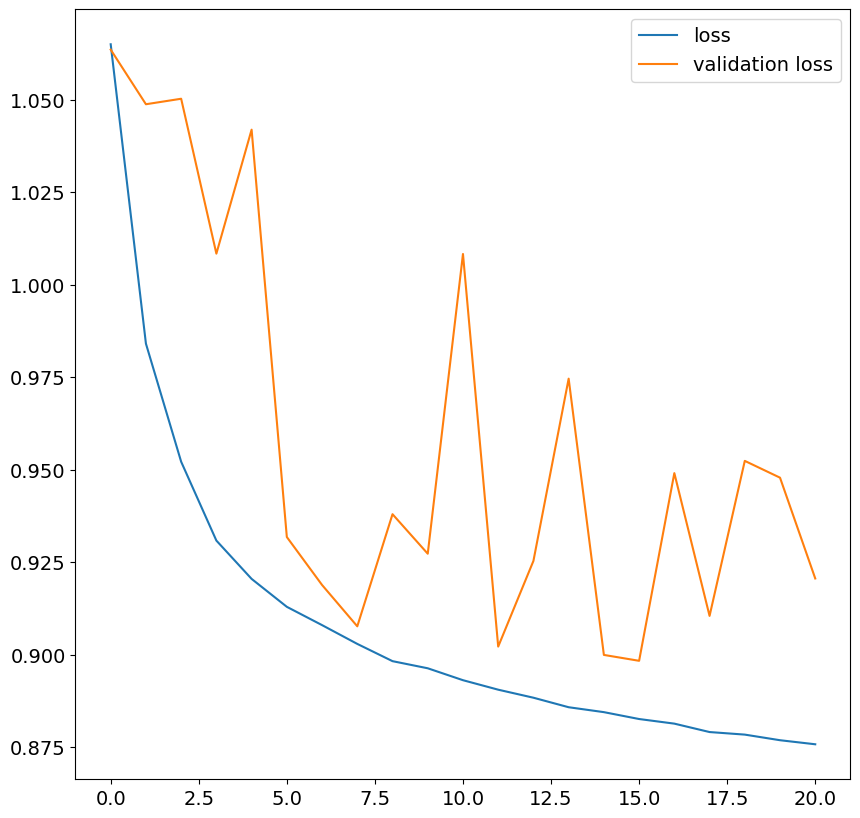

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

In [ ]:
predjettransformer_ytrain = jettransformermodel.predict(parts_train)
predjettransformer_yvalid = jettransformermodel.predict(parts_valid)
predjettransformer_ytest = jettransformermodel.predict(parts_test)

16500/16500 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


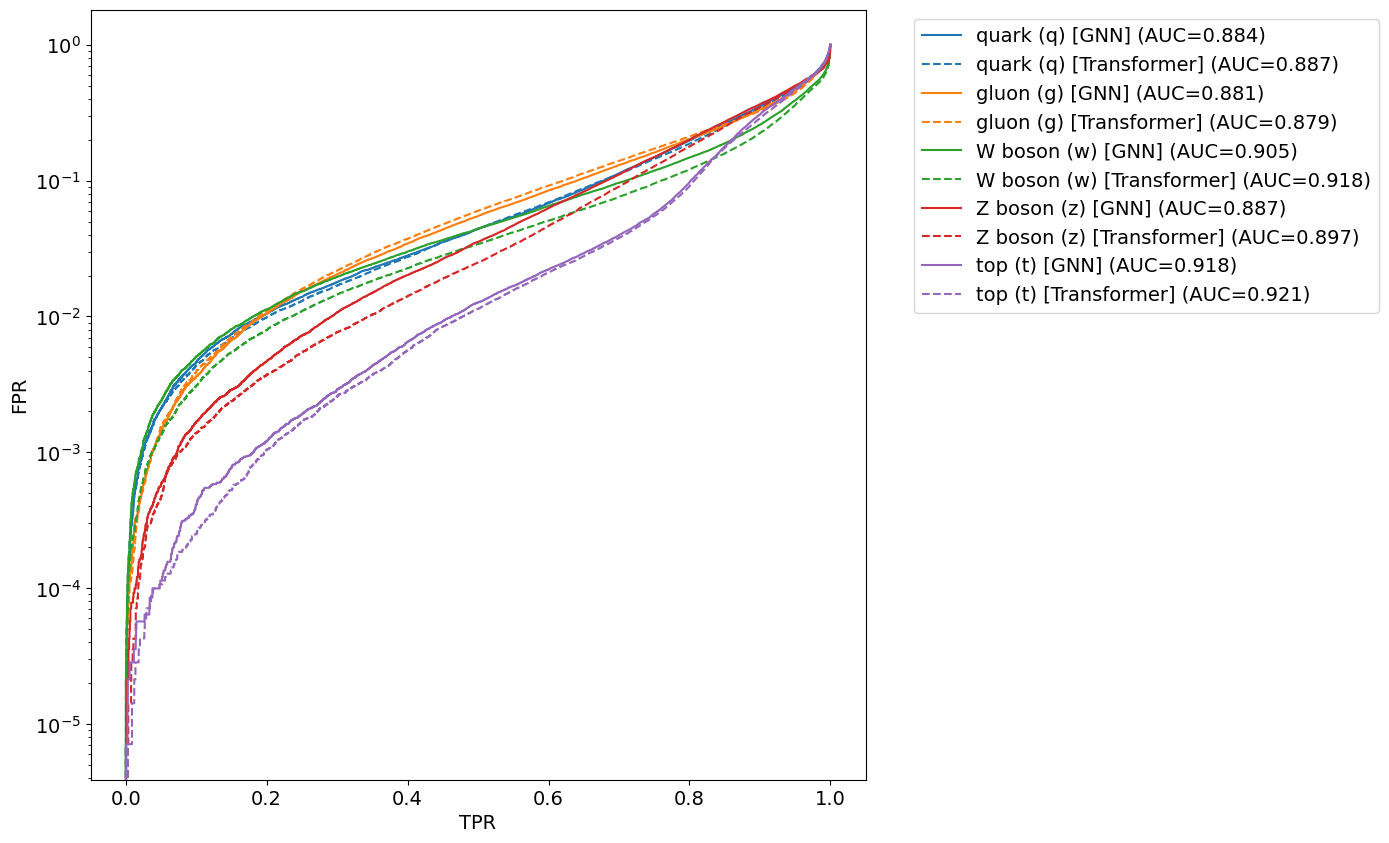

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

def plot_jetnet_roc(ysel_test,pred_ytests,log=True):
    for i in range(len(labelnames)):
        for j, alg in enumerate(pred_ytests):
            fpr, tpr, thresholds = roc_curve(ysel_test[alg][:,i] if isinstance(ysel_test, dict) else ysel_test[:,i], pred_ytests[alg][:,i])
            auc = roc_auc_score(ysel_test[alg][:,i] if isinstance(ysel_test, dict) else ysel_test[:,i], pred_ytests[alg][:,i])
            plt.plot(tpr,fpr, label='%s [%s] (AUC=%.3f)'%(labelnames[i],alg,auc),color='C%i'%i,linestyle=['solid','dashed','dotted','dashdot'][j])
    
    if log:
        plt.yscale('log')

    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.legend(bbox_to_anchor=(1.05, 1))

plot_jetnet_roc(labels_test,
                 {'GNN':predjetgnn_ytest, 'Transformer':predjettransformer_ytest},
                 log=True)

In [ ]:
from sklearn.metrics import accuracy_score
print("gnn accuracy = {}".format(accuracy_score(np.argmax(labels_test, axis=1), np.argmax(predjetgnn_ytest, axis=1))))
print("transformer accuracy = {}".format(accuracy_score(np.argmax(labels_test, axis=1), np.argmax(predjettransformer_ytest, axis=1))))

gnn accuracy = 0.6643068181818181
transformer accuracy = 0.6674829545454546


The transformer is pretty comparable to the gnn! But there is a caveat that this is only experimenting on a small set of data and with small model sizes, trained for short periods of time. Feel free to adjust any of these and see how it goes. You can also think of combining both to make a graph transformer. Recall that a gnn assumes explicit connections between particles, where information from one particle may need to propagate through multiple layers to reach another particle. On the transfomer side, a particle can directly attend to all other particles simultaneously through self-attention, but it does not assume any local structure, so a particle may attend equally to nearby or distant particles. With a graph transformer, the attention can be modified to be aware of the local graph structure. For example, we may add an edge bias to the attention scores before softmaxing, so that particles are still able to attend to all particles directly, but a preference is informed by the assumed graph connectivity...